In [1]:
import os
import zipfile
%load_ext autoreload

%autoreload 2

In [2]:
import tracemalloc
import psutil
import pprint
import pandas as pd
import uuid
import json
import os
import glob
import re
import sys
from bs4 import NavigableString, BeautifulSoup
from collections import defaultdict
import random
import string
import time

from utils.config import config
from utils.logger.logger import loggerCreator

# ePI Modules
from parse.rulebook.rulebook import StyleRulesDictionary

from parse.extractor.parser import parserExtractor
from match.matchDocument.matchDocument import MatchDocument
from documentAnnotation.documentAnnotation import DocumentAnnotation
from htmlDocTypePartitioner.partition import DocTypePartitioner
from extractContentBetweenHeadings.dataBetweenHeadingsExtractor import DataBetweenHeadingsExtractor
from fhirXmlGenerator.fhirXmlGenerator import FhirXmlGenerator
from fhirService.fhirService import FhirService
from utils.logger.matchLogger import MatchLogger
from languageInfo.documentTypeNames.documentTypeNames import DocumentTypeNames
from listBundle.addAndUpdateListBundle.addAndUpdateListBundle import ListBundleHandler

class FolderNotFoundError(Exception):
    pass

class Metrics:
    
    def __init__(self, logFileName, logger):
        self.logFileName = logFileName
        self.start()
        self.writer = open(self.logFileName, 'a')
        self.writer.write("StepName,Time,Current Memory,Peak Memory,Used Ram Percentage\n")
        self.finalPeak = 0
        self.finalTotalTime = 0
        self.finalUsedRamPerc = 0
        self.logger = logger
    
    def start(self):
        self.startTime = time.time()
        tracemalloc.start()
    
    def getMetric(self, msg):
        
        self.endTime = time.time()
        
        self.totalTime = self.endTime - self.startTime
        
        
        current, peak = tracemalloc.get_traced_memory()
        current = current / 10**6
        peak = peak / 10**6
        
        usedRamPerc = psutil.virtual_memory()[2]
        
        self.finalPeak = max(self.finalPeak, peak)
        self.finalUsedRamPerc = max(self.finalUsedRamPerc, usedRamPerc)

        self.finalTotalTime = self.finalTotalTime + self.totalTime
        #self.finalTotalTime = round(self.finalTotalTime/60,3)
        
        outputString = f"{msg},{round(self.totalTime/60,4)} Min,{current} MB,{peak} MB,{usedRamPerc}%\n"
        
        self.logger.logFlowCheckpoint(f"{outputString}")
        
        print(f"Metrics : {outputString}")
        self.writer.write(outputString)
        tracemalloc.stop()
        tracemalloc.start()
        self.startTime = time.time()
    def end(self):
        
        current, peak = tracemalloc.get_traced_memory()
        current = current / 10**6
        outputString = f"Final Metrics,{round(self.finalTotalTime/60,4)} Min,{current} MB,{self.finalPeak} MB,{self.finalUsedRamPerc}%\n"
        print(f"Metrics : {outputString}")
        self.logger.logFlowCheckpoint(f"{outputString}")
        self.writer.write(outputString)
        self.writer.close()
        tracemalloc.stop()
        
        


def convertToInt(x):
    try:
        return str(int(x))
    except:
        return x


def convertCollectionToDataFrame(collection):

    dfExtractedHier = pd.DataFrame(collection)
    dfExtractedHier['parent_id'] = dfExtractedHier['parent_id'].apply(
        lambda x: convertToInt(x))
    dfExtractedHier['id'] = dfExtractedHier['id'].apply(
        lambda x: convertToInt(x))

    return dfExtractedHier

def getRandomString(N):
    str_ = ''.join(random.choice(string.ascii_uppercase + string.digits
                                 + string.ascii_lowercase) for _ in range(N))
    return str_


def convertHtmlToJson(controlBasePath, basePath, domain, procedureType, languageCode, htmlDocName, fileNameQrd, fileNameLog):

    module_path = os.path.join(basePath)

    if "/" in basePath:
        pathSep = "/"
    else:
        pathSep = "\\"
    
    # Generate output folder path
    output_json_path = os.path.join(basePath, 'outputJSON')

    """
        Check if input folder exists, else throw exception
    """
    if(os.path.exists(module_path)):
        filenames = glob.glob(os.path.join(module_path, htmlDocName))

        # Create language specific folder in outputJSON folder if it doesn't exist
        if(not os.path.exists(output_json_path)):
            os.mkdir(output_json_path)
        logger = MatchLogger(f'Parser_{getRandomString(1)}', htmlDocName,
                             domain, procedureType, languageCode, "HTML", fileNameLog)

        styleLogger = MatchLogger(
            f'Style Dictionary_{getRandomString(1)}', htmlDocName, domain, procedureType, languageCode, "HTML", fileNameLog)

        styleRulesObj = StyleRulesDictionary(logger=styleLogger,
                                             controlBasePath=controlBasePath,
                                             language=languageCode,
                                             fileName=fileNameQrd,
                                             domain=domain,
                                             procedureType=procedureType
                                             )

        parserObj = parserExtractor(config, logger, styleRulesObj.styleRuleDict,
                                    styleRulesObj.styleFeatureKeyList,
                                    styleRulesObj.qrd_section_headings)

        for input_filename in filenames:
          # if(input_filename.find('Kalydeco II-86-PI-clean')!=-1):
            output_filename = os.path.join(output_json_path, htmlDocName)
            style_filepath =  output_filename.replace('.html','.txt')
            style_filepath =  style_filepath.replace('.txtl','.txt')
            style_filepath =  style_filepath.replace('.htm','.txt')
            print("-------------",style_filepath,"-----------------")

            output_filename = output_filename.replace('.html', '.json')
            output_filename = output_filename.replace('.htm', '.json')
            print(input_filename, output_filename)
            parserObj.createPIJsonFromHTML(input_filepath=input_filename,
                                           output_filepath=output_filename,
                                           style_filepath = style_filepath,
                                           img_base64_dict=parserObj.convertImgToBase64(input_filename)
                                           )
            
        return output_filename.split(pathSep)[-1], style_filepath
    else:
        try:    
            raise FolderNotFoundError(module_path + " not found")
        except:  
            logger.logFlowCheckpoint("Folder For Language Code Not Found In Input File")
            logger.logException("Folder For Language Code Not Found In Input File")
        raise FolderNotFoundError(module_path + " not found")
        return None


def splitJson(controlBasePath, basePath, domain, procedureType, languageCode, fileNameJson, fileNameQrd, fileNameLog):

    styleLogger = MatchLogger(
        f'Style Dictionary_{getRandomString(1)}', fileNameJson, domain, procedureType, languageCode, "Json", fileNameLog)

    styleRulesObj = StyleRulesDictionary(logger=styleLogger,
                                        controlBasePath=controlBasePath,
                                        language=languageCode,
                                        fileName=fileNameQrd,
                                        domain=domain,
                                        procedureType=procedureType
                                        )
    
    path_json = os.path.join(basePath,'outputJSON', fileNameJson)
    print("PathJson",path_json)
    partitionLogger = MatchLogger(
        f'Partition_{getRandomString(1)}', fileNameJson, domain, procedureType, languageCode, "Json", fileNameLog)

    partitioner = DocTypePartitioner(partitionLogger, domain, procedureType)

    partitionedJsonPaths = partitioner.partitionHtmls(
        styleRulesObj.qrd_section_headings, path_json)

    return partitionedJsonPaths


def extractAndValidateHeadings(controlBasePath,
                                basePath,
                                domain,
                                procedureType,
                                languageCode,
                                documentNumber,
                                fileNameDoc,
                                fileNameQrd,
                                fileNameMatchRuleBook,
                                fileNameDocumentTypeNames,
                                fileNameLog,
                                stopWordFilterLen=6,
                                isPackageLeaflet=False,
                                medName=None
                                ):

    if documentNumber == 0:
        topHeadingsConsidered = 4
        bottomHeadingsConsidered = 6
    elif documentNumber == 1:
        topHeadingsConsidered = 3
        bottomHeadingsConsidered = 5
    elif documentNumber == 2:
        topHeadingsConsidered = 5
        bottomHeadingsConsidered = 15
    else:
        topHeadingsConsidered = 5
        bottomHeadingsConsidered = 10

    print(f"Starting Heading Extraction For File :- {fileNameDoc}")
    logger = MatchLogger(f"Heading Extraction {fileNameDoc}_{getRandomString(1)}", fileNameDoc, domain, procedureType, languageCode, documentNumber, fileNameLog)
    logger.logFlowCheckpoint("Starting Heading Extraction")

    stopWordlanguage = DocumentTypeNames(
        controlBasePath=controlBasePath,
        fileNameDocumentTypeNames=fileNameDocumentTypeNames,
        languageCode=languageCode,
        domain=domain,
        procedureType=procedureType,
        documentNumber=documentNumber
        ).extractStopWordLanguage()

    matchDocObj = MatchDocument(
        logger,
        controlBasePath,
        basePath,
        domain,
        procedureType,
        languageCode,
        documentNumber,
        fileNameDoc,
        fileNameQrd,
        fileNameMatchRuleBook,
        fileNameDocumentTypeNames,
        topHeadingsConsidered,
        bottomHeadingsConsidered,
        stopWordFilterLen,
        stopWordlanguage,
        isPackageLeaflet,
        medName)
    df, coll, documentType = matchDocObj.matchHtmlHeaddingsWithQrd()

    return df, coll, documentType


def parseDocument(controlBasePath,
                  basePath,
                  htmlDocName,
                  fileNameQrd,
                  fileNameMatchRuleBook,
                  fileNameDocumentTypeNames,
                  jsonTempFileName,
                  listBundleDocumentTypeCodesFileName,
                  apiMmgtBaseUrl,
                  getListApiEndPointUrlSuffix,
                  addUpdateListApiEndPointUrlSuffix,
                  addBundleApiEndPointUrlSuffix,
                  apiMmgtSubsKey,
                  medName = None):
    
    listRegulatedAuthCodesAccrossePI = []
    
    if "/" in basePath:
        pathSep = "/"        
    else:
        pathSep = "\\"
    
    fileNameLog = os.path.join(basePath,'FinalLog.txt')

    pathComponents = basePath.split(pathSep)
    print(pathComponents, htmlDocName)
    timestamp = pathComponents[-1]
    languageCode =  pathComponents[-2]
    medName = pathComponents[-3]
    procedureType = pathComponents[-4]
    domain = pathComponents[-5]

    print(timestamp, languageCode, medName, procedureType, domain)
        
    flowLogger =  MatchLogger(f"Flow Logger HTML_{getRandomString(1)}", htmlDocName, domain, procedureType, languageCode, "HTML", fileNameLog)
    
    metrics = Metrics(os.path.join(basePath,'Metrics.csv'),flowLogger)
    
    
    flowLogger.logFlowCheckpoint("Starting HTML Conversion To Json")
    ###Convert Html to Json
    fileNameJson, stylesFilePath = convertHtmlToJson(controlBasePath, basePath, domain, procedureType, languageCode, htmlDocName, fileNameQrd, fileNameLog)
    
    print("stylePath:-",stylesFilePath)
    flowLogger.logFlowCheckpoint("Completed HTML Conversion To Json")
    metrics.getMetric("HTML Conversion To Json")

    flowLogger.logFlowCheckpoint("Starting Json Split")

    ###Split Uber Json to multiple Jsons for each category.
    partitionedJsonPaths = splitJson(controlBasePath, basePath, domain, procedureType, languageCode, fileNameJson, fileNameQrd, fileNameLog)
    
    partitionedJsonPaths = [ path.split(pathSep)[-1] for path in partitionedJsonPaths]
    flowLogger.logFlowCheckpoint(str(partitionedJsonPaths))
    
    flowLogger.logFlowCheckpoint("Completed Json Split")
    metrics.getMetric("Split Json")
    
    flowLogger.logFlowCheckpoint("Started Processing Partitioned Jsons")
    
    for index, fileNamePartitioned in enumerate(partitionedJsonPaths):
        #print("Index", index)
        #if index in [2,3]:
        #    continue
        
        flowLogger.logFlowCheckpoint(f"\n\n\n\n||||||||||||||||||||||||||||||||{str(index)} ||||| {str(fileNamePartitioned)}||||||||||||||||||||||||||||||||\n\n\n\n")
        
        if index == 3:
            stopWordFilterLen = 100
            isPackageLeaflet = True
        else:
            stopWordFilterLen = 6
            isPackageLeaflet = False
            
        df, coll, documentType = extractAndValidateHeadings(controlBasePath,
                                    basePath,
                                    domain,
                                    procedureType,
                                    languageCode,
                                    index,
                                    fileNamePartitioned,
                                    fileNameQrd,
                                    fileNameMatchRuleBook,
                                    fileNameDocumentTypeNames,
                                    fileNameLog,
                                    stopWordFilterLen=stopWordFilterLen,
                                    isPackageLeaflet=isPackageLeaflet,
                                    medName=medName)
        
        print(f"Completed Heading Extraction For File")
        flowLogger.logFlowCheckpoint("Completed Heading Extraction For File")
        metrics.getMetric(f"{index}: Heading Extraction")

        print(f"Starting Document Annotation For File :- {fileNamePartitioned}")        
        flowLogger.logFlowCheckpoint("Starting Document Annotation For File")
        documentAnnotationObj = DocumentAnnotation(fileNamePartitioned,'c20835db4b1b4e108828a8537ff41506','https://spor-sit.azure-api.net/pms/api/v2/',df,coll, index)
        try:
            pms_oms_annotation_data = documentAnnotationObj.processRegulatedAuthorizationForDoc()
            print(pms_oms_annotation_data)
        except Exception as e:
            pms_oms_annotation_data = None
            print("Error Found", str(e))
            
        print(f"Completed Document Annotation")        
        flowLogger.logFlowCheckpoint("Completed Document Annotation")
        metrics.getMetric(f"{index}: Document Annotation")
        
        print(f"Starting Extracting Content Between Heading For File :- {fileNamePartitioned}")        
        flowLogger.logFlowCheckpoint("Starting Extracting Content Between Heading")
        
        extractContentlogger =  MatchLogger(f'ExtractContentBetween_{index}_{getRandomString(1)}', fileNamePartitioned, domain, procedureType, languageCode, index, fileNameLog)
        extractorObj = DataBetweenHeadingsExtractor(extractContentlogger, basePath, coll)
        dfExtractedHierRR = extractorObj.extractContentBetweenHeadings(fileNamePartitioned)
        
        print(f"Completed Extracting Content Between Heading")        
        flowLogger.logFlowCheckpoint("Completed Extracting Content Between Heading")
        metrics.getMetric(f"{index}: Content Extraction")
        
        
        xmlLogger =  MatchLogger(f'XmlGeneration_{index}_{getRandomString(1)}', fileNamePartitioned, domain, procedureType, languageCode, index, fileNameLog)
        fhirXmlGeneratorObj = FhirXmlGenerator(xmlLogger, controlBasePath, basePath, pms_oms_annotation_data, stylesFilePath, medName)
        fileNameXml = fileNamePartitioned.replace('.json','.xml')
        generatedXml = fhirXmlGeneratorObj.generateXml(dfExtractedHierRR, fileNameXml)
        
        metrics.getMetric(f"{index}: Generate XML")
        
        fhirServiceLogger =  MatchLogger(f'XML Submission Logger_{index}_{getRandomString(1)}', fileNamePartitioned, domain, procedureType, languageCode, index, fileNameLog)
        
        fhirServiceObj = FhirService(fhirServiceLogger, apiMmgtBaseUrl, addBundleApiEndPointUrlSuffix, apiMmgtSubsKey, basePath, generatedXml)
        fhirServiceObj.submitFhirXml()
        
        
        
        
        metrics.getMetric(f"{index}: Submit FHIR Msg")
        
        print(f"Created XML File For :- {fileNamePartitioned}")
        
        flowLogger.logFlowCheckpoint("Starting list bundle update/addition")
        if documentAnnotationObj.listRegulatedAuthorizationIdentifiers != None:
            for id in documentAnnotationObj.listRegulatedAuthorizationIdentifiers:
                listRegulatedAuthCodesAccrossePI.append(id)
        listBundleLogger =  MatchLogger(f'List Bundle Creation Logger_{index}_{getRandomString(1)}', fileNamePartitioned, domain, procedureType, languageCode, index, fileNameLog)
        print("\nlistRegulatedAuthCodesAccrossePI",listRegulatedAuthCodesAccrossePI)
        try:
            listBundleHandler = ListBundleHandler(listBundleLogger,
                     domain,
                     procedureType,
                     index,
                     documentType,
                     languageCode,
                     medName,
                     controlBasePath,
                     jsonTempFileName,
                     listBundleDocumentTypeCodesFileName,
                     fileNameDocumentTypeNames,
                     listRegulatedAuthCodesAccrossePI,
                     apiMmgtBaseUrl,
                     getListApiEndPointUrlSuffix,
                     addUpdateListApiEndPointUrlSuffix,
                     apiMmgtSubsKey)

            listBundleXml = listBundleHandler.addOrUpdateDocumentItem(str(fhirServiceObj.SubmittedFhirMsgRefId))
            listBundleHandler.submitListXmLToServer(listBundleXml)

            flowLogger.logFlowCheckpoint("Completed list bundle update/addition")
            metrics.getMetric(f"{index}: Update/Add List Bundle")
            #return df,coll,dfExtractedHierRR
        except Exception as e:
            print(str(e))
            if 'No MAN Code found' in str(e):
                flowLogger.logFlowCheckpoint("Skipping list bundle addtion/update as no MAN found")
            
    
    flowLogger.logFlowCheckpoint("Completed Processing Partitioned Jsons")
    metrics.getMetric(f"{index}: Completed")
    metrics.end()

C:\Users\vipsharm\AppData\Local\Continuum\anaconda3\envs\py38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vipsharm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from wordToHtmlConvertor.wordToHtmlConvertor import WordToHtmlConvertor

wordToHtmlConvertorObj = WordToHtmlConvertor()
wordToHtmlConvertorObj.convertWordToHTML()

In [3]:
# inputZipFolderPath = "F:\Projects\EMA\Repository\EMA EPI PoC\\function_code\\inputblob"
inputZipFolderPath = os.path.abspath(os.path.join('..'))
inputZipFolderPath = os.path.join(inputZipFolderPath, 'inputblob')
inputZipFileName = "ELOCTA~H~CAP~de~2021-05-22T18-23-40Z.zip"

In [4]:
fileNameQrd = 'qrd_canonical_model.csv'
fileNameMatchRuleBook = 'ruleDict.json'
fileNameDocumentTypeNames = 'documentTypeNames.json'
fsMountName = '/mounted'
jsonTempFileName = 'listBundleJsonTemplate.json'
listBundleDocumentTypeCodesFileName = 'listBundleDocumentTypeCodes.json'
apiMmgtBaseUrl = "https://ema-dap-epi-tst-fhir-apim.azure-api.net"
getListApiEndPointUrlSuffix = "/epi/v1/List"
addUpdateListApiEndPointUrlSuffix = "/epi-w/v1/List"
addBundleApiEndPointUrlSuffix = "/epi-w/v1/Bundle"
apiMmgtSubsKey = "9e9d47b8a08148f9833e17462d90574a"



info = inputZipFileName.split("~")

try:
    medName = info[0]
    domain = info[1]
    procedureType = info[2]
    languageCode = info[3]
    timestamp = info[4]
    timestamp = timestamp.replace(".zip","")

except Exception:
    raise f"Missing required info in the zip file name {inputZipFileName}"

if "\\" in os.getcwd():
    localEnv = True
    inputZipFolderPath = os.path.join(os.path.abspath(os.path.join('..')),inputZipFolderPath)
    outputFolderPath = os.path.join(os.path.abspath(os.path.join('..')), 'work', f"{domain}", f"{procedureType}", f"{medName}", f"{languageCode}", f"{timestamp}")
    controlFolderPath = os.path.join(os.path.abspath(os.path.join('..')),'control')
else:
    localEnv = False
    inputZipFolderPath = os.path.join(f'{fsMountName}',inputZipFolderPath)
    outputFolderPath = os.path.join(f'{fsMountName}', 'work', f"{domain}", f"{procedureType}", f"{medName}", f"{languageCode}", f"{timestamp}")
    controlFolderPath = os.path.join(f'{fsMountName}','control')


print(inputZipFileName, inputZipFolderPath, outputFolderPath, controlFolderPath)

mode = 0o666

if localEnv is True:
    inputZipFolderPath = inputZipFolderPath.replace("/","\\")
    outputFolderPath = outputFolderPath.replace("/","\\")
    controlFolderPath = controlFolderPath.replace("/","\\")

try:
    os.makedirs(inputZipFolderPath, mode)
    os.makedirs(outputFolderPath, mode)
    os.makedirs(controlFolderPath, mode)

except Exception:
    print("Already Present")
    
with zipfile.ZipFile(f'{inputZipFolderPath}/{inputZipFileName}',"r") as zip_ref:
        zip_ref.extractall(outputFolderPath)
    

_,_,fileNames = next(os.walk(outputFolderPath))
htmlFileName = [fileName for fileName in fileNames if ".htm" in fileName][0]

print(htmlFileName)



ELOCTA~H~CAP~de~2021-05-22T18-23-40Z.zip F:\Projects\EMA\Repository\EMA EPI PoC\function_code\inputblob F:\Projects\EMA\Repository\EMA EPI PoC\function_code\work\H\CAP\ELOCTA\de\2021-05-22T18-23-40Z F:\Projects\EMA\Repository\EMA EPI PoC\function_code\control
Already Present
Elocta_clean.htm


2021-06-15 16:56:03,650 : Flow Logger HTML_s : Starting HTML Conversion To Json | H | CAP |  de | HTML | Elocta_clean.htm
2021-06-15 16:56:03,672 : Style Dictionary_H : Reading style dictionary in file: rule_dictionary_de.json | H | CAP |  de | HTML | Elocta_clean.htm


['F:', 'Projects', 'EMA', 'Repository', 'EMA EPI PoC', 'function_code', 'work', 'H', 'CAP', 'ELOCTA', 'de', '2021-05-22T18-23-40Z'] Elocta_clean.htm
2021-05-22T18-23-40Z de ELOCTA CAP H


2021-06-15 16:56:03,836 : Style Dictionary_H : Qrd Section Keys Retrieved For Style Dictionary: ZUSAMMENFASSUNG DER MERKMALE DES ARZNEIMITTELS, ANHANG II, A. ETIKETTIERUNG , B. PACKUNGSBEILAGE | H | CAP |  de | HTML | Elocta_clean.htm


------------- F:\Projects\EMA\Repository\EMA EPI PoC\function_code\work\H\CAP\ELOCTA\de\2021-05-22T18-23-40Z\outputJSON\Elocta_clean.txt -----------------
F:\Projects\EMA\Repository\EMA EPI PoC\function_code\work\H\CAP\ELOCTA\de\2021-05-22T18-23-40Z\Elocta_clean.htm F:\Projects\EMA\Repository\EMA EPI PoC\function_code\work\H\CAP\ELOCTA\de\2021-05-22T18-23-40Z\outputJSON\Elocta_clean.json


2021-06-15 16:56:06,539 : Parser_q : Style Information Stored In File: F:\Projects\EMA\Repository\EMA EPI PoC\function_code\work\H\CAP\ELOCTA\de\2021-05-22T18-23-40Z\outputJSON\Elocta_clean.txt | H | CAP |  de | HTML | Elocta_clean.htm


ANHANGI | 7
Element: -  <p align="center" class="MsoNormal" id="bb8bdb54-542e-4c52-8083-48bc9c578d90" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG I</span></b></p>
child: ANHANGI | 7
ANHANGI | 7
counts 7 7
b perctange in given element is 100.0
ANHANGI | 7
Element: -  <p align="center" class="MsoNormal" id="bb8bdb54-542e-4c52-8083-48bc9c578d90" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG I</span></b></p>
child: ANHANGI | 7
counts 0 7
u perctange in given element is 0.0
[]
ANHANGI | 7
Element: -  <p align="center" class="MsoNormal" id="bb8bdb54-542e-4c52-8083-48bc9c578d90" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG I</span></b></p>
child: ANHANGI | 7
counts 0 7
i perctange in given element is 0.0
[]
ANHANGI | 7
Element: -  <p align="center" class="MsoNormal" id="bb8bdb54-542e-4c52-8083-48bc9c578d90" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG I</span></b></p>
child: ANHANGI | 7
cou

child: ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
b perctange in given element is 0.0
[]
ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="da61c650-7918-4812-9999-a8458f3f811a" style="line-height:normal"><span lang="DE">ELOCTA 3000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
u perctange in given element is 0.0
[]
ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="da61c650-7918-4812-9999-a8458f3f811a" style="line-height:normal"><span lang="DE">ELOCTA 3000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
i perctange in given

ELOCTA 500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 78
Element: -  <p class="MsoNormal" id="df88b3e8-2b0d-4394-96a3-bc0c75add0d3" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 500 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></u></p>
child: ELOCTA 500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 78
counts 0 78
b perctange in given element is 0.0
[]
ELOCTA 500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 78
Element: -  <p class="MsoNormal" id="df88b3e8-2b0d-4394-96a3-bc0c75add0d3" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 500 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></u></p>
child: ELOCTA 500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 78
ELOCTA 500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 78
counts 78 78
u perctange in given ele

child: ELOCTA 1000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
ELOCTA 1000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 79 79
u perctange in given element is 100.0
ELOCTA 1000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="a278e91d-696b-47a7-a79b-89ed013493f8" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 1000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></u></p>
child: ELOCTA 1000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
i perctange in given element is 0.0
[]
ELOCTA 1000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="a278e91d-696b-47a7-a79b-89ed013493f8" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 1000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionsl

child: ELOCTA 2000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
b perctange in given element is 0.0
[]
ELOCTA 2000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="a306916f-c4ef-49f0-930f-85394b9ecf19" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 2000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></u></p>
child: ELOCTA 2000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
ELOCTA 2000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 79 79
u perctange in given element is 100.0
ELOCTA 2000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="a306916f-c4ef-49f0-930f-85394b9ecf19" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">ELOCTA 2000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionsl

child: ELOCTA 4000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
ELOCTA 4000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 79 79
u perctange in given element is 100.0
ELOCTA 4000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="Default" id="77f300d0-f7dd-4ada-af81-d7df5d3f5472" style="page-break-after:avoid"><u><span lang="DE" style="font-size:11.0pt;color:windowtext">ELOCTA 4000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></u></p>
child: ELOCTA 4000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
i perctange in given element is 0.0
[]
ELOCTA 4000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="Default" id="77f300d0-f7dd-4ada-af81-d7df5d3f5472" style="page-break-after:avoid"><u><span lang="DE" style="font-size:11.0pt;color:windowtext">ELOCTA 4000 I.E. Pulver und Lösun

child: Efmoroctocog alfa (rekombinanter humaner GerinnungsfaktorVIII, Fc‑Fusionsprotein [rFVIIIFc]) besteht aus 1.890Aminosäuren. Es wird mittels rekombinanter DNA‑Technologie in einer humanen embryonalen Nierenzelllinie (HEK‑Zelllinie) ohne Verwendung jeglicher exogener Proteine menschlichen oder tierischen Ursprungs während des Zellkulturprozesses, der Aufreinigung oder endgültigen Formulierung, hergestellt. | 406
counts 0 406
b perctange in given element is 0.0
[]
Efmoroctocog alfa (rekombinanter humaner GerinnungsfaktorVIII, Fc‑Fusionsprotein [rFVIIIFc]) besteht aus 1.890Aminosäuren. Es wird mittels rekombinanter DNA‑Technologie in einer humanen embryonalen Nierenzelllinie (HEK‑Zelllinie) ohne Verwendung jeglicher exogener Proteine menschlichen oder tierischen Ursprungs während des Zellkulturprozesses, der Aufreinigung oder endgültigen Formulierung, hergestellt. | 406
Element: -  <p class="MsoNormal" id="8c3e1a61-fa5b-4a4e-b238-093950f1648d" style="line-height:normal"><span lang="D

counts 19 19
b perctange in given element is 100.0
3. DARREICHUNGSFORM | 19
Element: -  <p class="MsoNormal" id="14ffa91f-8012-4717-867f-59c406b5712b" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">3.       DARREICHUNGSFORM</span></b></p>
child: 3. DARREICHUNGSFORM | 19
counts 0 19
u perctange in given element is 0.0
[]
3. DARREICHUNGSFORM | 19
Element: -  <p class="MsoNormal" id="14ffa91f-8012-4717-867f-59c406b5712b" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">3.       DARREICHUNGSFORM</span></b></p>
child: 3. DARREICHUNGSFORM | 19
counts 0 19
i perctange in given element is 0.0
[]
3. DARREICHUNGSFORM | 19
Element: -  <p class="MsoNormal" id="14ffa91f-8012-4717-867f-59c406b5712b" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">3.       DARREICHUNGSFORM</span></b></p>
child: 3. DARREICHUNGSFORM | 19
counts 0 19
em perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer Injektionslösung. | 64

[]
ELOCTA kann bei allen Altersgruppen angewendet werden. | 54
Element: -  <p class="MsoNormal" id="1f406397-8e1d-44a1-93b0-b892a73e3a39" style="line-height:normal"><span lang="DE">ELOCTA kann bei allen Altersgruppen angewendet werden.</span></p>
child: ELOCTA kann bei allen Altersgruppen angewendet werden. | 54
counts 0 54
b perctange in given element is 0.0
[]
ELOCTA kann bei allen Altersgruppen angewendet werden. | 54
Element: -  <p class="MsoNormal" id="1f406397-8e1d-44a1-93b0-b892a73e3a39" style="line-height:normal"><span lang="DE">ELOCTA kann bei allen Altersgruppen angewendet werden.</span></p>
child: ELOCTA kann bei allen Altersgruppen angewendet werden. | 54
counts 0 54
u perctange in given element is 0.0
[]
ELOCTA kann bei allen Altersgruppen angewendet werden. | 54
Element: -  <p class="MsoNormal" id="1f406397-8e1d-44a1-93b0-b892a73e3a39" style="line-height:normal"><span lang="DE">ELOCTA kann bei allen Altersgruppen angewendet werden.</span></p>
child: ELOCTA kann bei allen 

[]
Während des Behandlungsverlaufs wird eine angemessene Kontrolle der Faktor-VIII-Spiegel (mittels Einstufen-Gerinnungs- oder chromogenen Test) empfohlen, um bei Bedarf die anzuwendende Dosis und die Frequenz der wiederholten Injektionen anzupassen. Einzelne Patienten können unterschiedlich auf FaktorVIII ansprechen, wodurch es zu unterschiedlichen Halbwertszeiten und Wiederfindungsraten kommen kann. Die Dosierung auf Basis des Körpergewichts muss für unter- oder übergewichtigen Patienten unter Umständen angepasst werden. Insbesondere im Fall von großen chirurgischen Eingriffen ist eine genaue gerinnungsanalytische Überwachung (Faktor‑VIII-Aktivität im Plasma) der Substitutionstherapie unbedingt erforderlich. | 716
Element: -  <p class="MsoNormal" id="d38a3f6a-b86e-439a-ae96-9a30f417ac34" style="line-height:normal"><span lang="DE">Während des Behandlungsverlaufs wird eine angemessene Kontrolle der Faktor-VIII-Spiegel (mittels Einstufen-Gerinnungs- oder chromogenen Test) empfohlen, um 

[]
Eine I.E. der Aktivität des rekombinanten Faktor‑VIII‑Fc-Proteins entspricht dem Faktor‑VIII-Gehalt von 1ml humanem Normalplasma. | 129
Element: -  <p class="MsoNormal" id="7b2ef53a-1712-4454-9017-a1624fae7832" style="line-height:normal;text-autospace:none"><span lang="DE">Eine I.E. der Aktivität des rekombinanten Faktor‑VIII‑Fc-Proteins entspricht dem Faktor‑VIII-Gehalt von 1 ml humanem Normalplasma.</span></p>
child: Eine I.E. der Aktivität des rekombinanten Faktor‑VIII‑Fc-Proteins entspricht dem Faktor‑VIII-Gehalt von 1ml humanem Normalplasma. | 129
counts 0 129
i perctange in given element is 0.0
[]
Eine I.E. der Aktivität des rekombinanten Faktor‑VIII‑Fc-Proteins entspricht dem Faktor‑VIII-Gehalt von 1ml humanem Normalplasma. | 129
Element: -  <p class="MsoNormal" id="7b2ef53a-1712-4454-9017-a1624fae7832" style="line-height:normal;text-autospace:none"><span lang="DE">Eine I.E. der Aktivität des rekombinanten Faktor‑VIII‑Fc-Proteins entspricht dem Faktor‑VIII-Gehalt von 1 ml hum

em perctange in given element is 0.0
[]
Bei den folgenden Blutungsereignissen sollte die Faktor‑VIII-Aktivität (in % des Normbereichs oder in I.E./dl) während des entsprechenden Zeitraums nicht unter den angegebenen Plasmaspiegel abfallen. Tabelle1 dient als Empfehlung für die Dosierung bei Blutungsepisoden und chirurgischen Eingriffen: | 298
Element: -  <p class="MsoNormal" id="17ef52e2-c747-40c5-afbd-9dc6494e9450" style="line-height:normal"><span lang="DE">Bei den folgenden Blutungsereignissen sollte die Faktor‑VIII-Aktivität (in % des Normbereichs oder in I.E./dl) während des entsprechenden Zeitraums nicht unter den angegebenen Plasmaspiegel abfallen. Tabelle 1 dient als Empfehlung für die Dosierung bei Blutungsepisoden und chirurgischen Eingriffen:</span></p>
child: Bei den folgenden Blutungsereignissen sollte die Faktor‑VIII-Aktivität (in % des Normbereichs oder in I.E./dl) während des entsprechenden Zeitraums nicht unter den angegebenen Plasmaspiegel abfallen. Tabelle1 dient als 

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Schweregrad der Blutung / Art des chirurgischen Eingriffs | 57
Schweregrad der Blutung / Art des chirurgischen Eingriffs | 57
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erforderlicher Faktor-VIII-Spiegel (%) (I.E./dl) | 48
Erforderlicher Faktor-VIII-Spiegel (%) (I.E./dl) | 48
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeit der Anwendung (Stunden)/ Dauer der Behandlung (Tage) | 63
Häufigkeit der Anwendung (Stunden)/ Dauer der Behandlung (Tage) | 63
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Blutung | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Beginnende Hämarthrosen, Muskelblutungen oder Blutungen im   Mundber

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Umfangreichere Hämarthrosen, Muskelblutungen oder Hämatome | 58
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 30 ‑ 60 | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Wiederholung der   Injektion alle 12 bis 24Stunden über 3‑4Tage oder länger bis   zur Beseitigung des Schmerzzustandes und der akuten Beeinträchtigung. | 151
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Lebensbedrohliche Blutungen | 27
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 60 ‑ 100 | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Wiederholung der   Injektion alle 8 bis 24Stunden, bis die Gefährdung beseitigt ist. | 84
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Chirurgischer Eingriff | 22
Chirurgi

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeit der Anwendung (Stunden)/ Dauer der Behandlung (Tage) | 63
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Blutung | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Beginnende Hämarthrosen, Muskelblutungen oder Blutungen im   Mundbereich | 72
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 20 ‑ 40 | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Wiederholung der   Injektion alle 12 bis 24Stunden, für mindestens einen Tag, bis die   Blutung (erkennbar durch Schmerzen) gestillt oder eine Wundheilung eingetreten   ist. | 173
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Schweregrad der Blutung / Art des chirurgischen Eingriffs | 57
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erforderlicher Faktor-VIII-Spiegel (%) (I.E./dl) | 48
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeit der Anwendung (Stunden)/ Dauer der Behandlung (Tage) | 63
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Blutung | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Beginnende Hämarthrosen, Muskelblutungen oder Blutungen im   Mundbereich | 72
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 20 ‑ 40 | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Wiederholung der   Injektion alle 12 bis 24Stunden, für

child: In einigen Fällen, besonders bei jungen Patienten, können kürzere Dosierungsintervalle oder höhere Dosen erforderlich sein. | 123
counts 0 123
em perctange in given element is 0.0
[]
Ältere Patienten | 16
Element: -  <p class="MsoNormal" id="7d57313a-c12e-4ec7-a2f9-c8a50c1840d2" style="line-height:normal;page-break-after:avoid;text-autospace:
none"><i><u><span lang="DE">Ältere Patienten</span></u></i></p>
child: Ältere Patienten | 16
counts 0 16
b perctange in given element is 0.0
[]
Ältere Patienten | 16
Element: -  <p class="MsoNormal" id="7d57313a-c12e-4ec7-a2f9-c8a50c1840d2" style="line-height:normal;page-break-after:avoid;text-autospace:
none"><i><u><span lang="DE">Ältere Patienten</span></u></i></p>
child: Ältere Patienten | 16
Ältere Patienten | 16
counts 16 16
u perctange in given element is 100.0
Ältere Patienten | 16
Element: -  <p class="MsoNormal" id="7d57313a-c12e-4ec7-a2f9-c8a50c1840d2" style="line-height:normal;page-break-after:avoid;text-autospace:
none"><i><u><s

child: ELOCTA wird über mehrere Minuten intravenös injiziert. Die Infusionsrate sollte sich nach dem Befinden des Patienten richten und 10ml/min nicht überschreiten. | 158
counts 0 158
em perctange in given element is 0.0
[]
Hinweise zur Rekonstitution des Arzneimittels vor der Anwendung, siehe Abschnitt6.6. | 84
Element: -  <p class="MsoNormal" id="c6add3c5-e4c7-4a11-bd62-40d218fcbea9" style="line-height:normal;text-autospace:none"><span lang="DE">Hinweise zur Rekonstitution des Arzneimittels vor der Anwendung, siehe Abschnitt 6.6.</span></p>
child: Hinweise zur Rekonstitution des Arzneimittels vor der Anwendung, siehe Abschnitt6.6. | 84
counts 0 84
b perctange in given element is 0.0
[]
Hinweise zur Rekonstitution des Arzneimittels vor der Anwendung, siehe Abschnitt6.6. | 84
Element: -  <p class="MsoNormal" id="c6add3c5-e4c7-4a11-bd62-40d218fcbea9" style="line-height:normal;text-autospace:none"><span lang="DE">Hinweise zur Rekonstitution des Arzneimittels vor der Anwendung, siehe Abs

Allergische Überempfindlichkeitsreaktionen auf ELOCTA sind möglich. Falls Symptome einer Überempfindlichkeit auftreten, sollte den Patienten angewiesen werden, die Anwendung des Arzneimittels sofort zu unterbrechen und ihren Arzt aufzusuchen. | 242
Element: -  <p class="MsoNormal" id="e530e3b8-8dd2-4993-9b01-1894439f33b6" style="line-height:normal"><span lang="DE">Allergische Überempfindlichkeitsreaktionen auf ELOCTA sind möglich. Falls Symptome einer Überempfindlichkeit auftreten, sollte den Patienten angewiesen werden, die Anwendung des Arzneimittels sofort zu unterbrechen und ihren Arzt aufzusuchen.</span></p>
child: Allergische Überempfindlichkeitsreaktionen auf ELOCTA sind möglich. Falls Symptome einer Überempfindlichkeit auftreten, sollte den Patienten angewiesen werden, die Anwendung des Arzneimittels sofort zu unterbrechen und ihren Arzt aufzusuchen. | 242
counts 0 242
b perctange in given element is 0.0
[]
Allergische Überempfindlichkeitsreaktionen auf ELOCTA sind möglich. Fal

Element: -  <p class="MsoNormal" id="e813273a-aa52-475d-bcd3-85218156ad6c" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Inhibitoren</span></u></p>
child: Inhibitoren | 11
counts 0 11
i perctange in given element is 0.0
[]
Inhibitoren | 11
Element: -  <p class="MsoNormal" id="e813273a-aa52-475d-bcd3-85218156ad6c" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Inhibitoren</span></u></p>
child: Inhibitoren | 11
counts 0 11
em perctange in given element is 0.0
[]
Die Bildung neutralisierender Antikörper (Inhibitoren) gegen FaktorVIII ist eine bekannte Komplikation bei der Behandlung von Patienten mit HämophilieA. Diese Inhibitoren sind im Allgemeinen gegen die prokoagulatorische Aktivität des FaktorVIII gerichtete IgG‑Immunglobuline, die in Bethesda‑Einheiten (B.E.) pro ml Plasma mittels modifizierten Assays quantifiziert werden. Das Risiko der Bildung von Inhibitoren korreliert mit dem Schweregrad der Erkrankung sowie der Exposition gegenüber 

[]
Im Allgemeinen sollten alle Patienten, die mit Gerinnungsfaktor‑VIII-Produkten behandelt werden, sorgfältig mit Hilfe geeigneter klinischer Beobachtungen und Laboruntersuchungen auf die Entwicklung von Inhibitoren überwacht werden. Wenn die erwarteten Plasmaspiegel der Faktor‑VIII-Aktivität nicht erreicht werden oder die Blutung mit einer angemessenen Dosis nicht kontrolliert werden kann, soll ein Test zum Nachweis von Faktor‑VIII-Inhibitoren durchgeführt werden. Bei Patienten mit hohen Inhibitorspiegeln kann die Faktor‑VIII-Behandlung unwirksam sein und es sollten andere Behandlungsmöglichkeiten erwogen werden. Die Behandlung solcher Patienten soll von Ärzten durchgeführt werden, die Erfahrung mit der Behandlung von Hämophilie und Faktor‑VIII-Inhibitoren haben. | 772
Element: -  <p class="MsoNormal" id="9550ba1e-65ca-432f-b10c-c98de2f14ba9" style="line-height:normal"><span lang="DE">Im Allgemeinen sollten alle Patienten, die mit Gerinnungsfaktor‑VIII-Produkten behandelt werden, sor

Rückverfolgbarkeit | 18
Element: -  <p class="MsoNormal" id="5d44e9a1-a0a0-4b46-b97d-72847fc0f87d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Rückverfolgbarkeit</span></u></p>
child: Rückverfolgbarkeit | 18
counts 0 18
b perctange in given element is 0.0
[]
Rückverfolgbarkeit | 18
Element: -  <p class="MsoNormal" id="5d44e9a1-a0a0-4b46-b97d-72847fc0f87d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Rückverfolgbarkeit</span></u></p>
child: Rückverfolgbarkeit | 18
Rückverfolgbarkeit | 18
counts 18 18
u perctange in given element is 100.0
Rückverfolgbarkeit | 18
Element: -  <p class="MsoNormal" id="5d44e9a1-a0a0-4b46-b97d-72847fc0f87d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Rückverfolgbarkeit</span></u></p>
child: Rückverfolgbarkeit | 18
counts 0 18
i perctange in given element is 0.0
[]
Rückverfolgbarkeit | 18
Element: -  <p class="MsoNormal" id="5d44e9a1-a0a0-4b46-b97d-72847fc0f87d" style="line-height:normal

child: Je nach Körpergewicht und Dosierung könnte der Patient jedoch mehr als eine Durchstechflasche erhalten (Informationen zum Inhalt pro Durchstechflasche siehe Abschnitt2). Dies ist zu berücksichtigen bei Patienten, die eine natriumarme Diät einhalten sollen. | 256
counts 0 256
u perctange in given element is 0.0
[]
Je nach Körpergewicht und Dosierung könnte der Patient jedoch mehr als eine Durchstechflasche erhalten (Informationen zum Inhalt pro Durchstechflasche siehe Abschnitt2). Dies ist zu berücksichtigen bei Patienten, die eine natriumarme Diät einhalten sollen. | 256
Element: -  <p class="MsoNormal" id="6427cb3f-360c-4859-ba82-19080224a18c" style="line-height:normal"><span lang="DE">Je nach Körpergewicht und Dosierung könnte der Patient jedoch mehr als eine Durchstechflasche erhalten (Informationen zum Inhalt pro Durchstechflasche siehe Abschnitt 2). Dies ist zu berücksichtigen bei Patienten, die eine natriumarme Diät einhalten sollen.</span></p>
child: Je nach Körpergewicht

[]
4.6 Fertilität, Schwangerschaft und Stillzeit | 45
Element: -  <p class="MsoNormal" id="7b1d7668-3305-4111-bf0a-bb632feaea70" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;text-autospace:none"><b><span lang="DE">4.6     Fertilität, Schwangerschaft und Stillzeit</span></b></p>
child: 4.6 Fertilität, Schwangerschaft und Stillzeit | 45
counts 0 45
em perctange in given element is 0.0
[]
Reproduktionsstudien am Tier wurden mit FaktorVIII nicht durchgeführt. In einer Studie mit ELOCTA wurde die Plazentagängigkeit bei Mäusen untersucht (siehe Abschnitt5.3). Aufgrund des seltenen Vorkommens der HämophilieA bei Frauen liegen keine Erfahrungen über die Anwendung von FaktorVIII während der Schwangerschaft und Stillzeit vor. Daher sollte FaktorVIII in der Schwangerschaft und Stillzeit nur bei eindeutiger Indikationsstellung angewendet werden. | 456
Element: -  <p class="Default" id="640b776c-311a-463b-a474-131aff4b23be"><span lang="DE" style="font-s

child: 4.8 Nebenwirkungen | 18
counts 0 18
i perctange in given element is 0.0
[]
4.8 Nebenwirkungen | 18
Element: -  <p class="MsoNormal" id="10586632-a6e1-439d-91c2-dcb5acda47c8" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;text-autospace:none"><b><span lang="DE">4.8     Nebenwirkungen</span></b></p>
child: 4.8 Nebenwirkungen | 18
counts 0 18
em perctange in given element is 0.0
[]
Zusammenfassung des Sicherheitsprofils | 38
Element: -  <p class="Default" id="b19b57b2-4513-433f-b51f-276347e30136" style="page-break-after:avoid;text-autospace:ideograph-numeric ideograph-other"><u><span lang="DE" style="font-size:11.0pt;color:windowtext">Zusammenfassung des Sicherheitsprofils</span></u></p>
child: Zusammenfassung des Sicherheitsprofils | 38
counts 0 38
b perctange in given element is 0.0
[]
Zusammenfassung des Sicherheitsprofils | 38
Element: -  <p class="Default" id="b19b57b2-4513-433f-b51f-276347e30136" style="page-break-after:avoid;text-a

u perctange in given element is 100.0
Tabellarische Auflistung der Nebenwirkungen | 43
Element: -  <p class="Default" id="19bfbbe0-a81f-4a03-bcf7-e31d0cd6c726" style="page-break-after:avoid;text-autospace:ideograph-numeric ideograph-other"><u><span lang="DE" style="font-size:11.0pt;color:windowtext">Tabellarische Auflistung der Nebenwirkungen</span></u></p>
child: Tabellarische Auflistung der Nebenwirkungen | 43
counts 0 43
i perctange in given element is 0.0
[]
Tabellarische Auflistung der Nebenwirkungen | 43
Element: -  <p class="Default" id="19bfbbe0-a81f-4a03-bcf7-e31d0cd6c726" style="page-break-after:avoid;text-autospace:ideograph-numeric ideograph-other"><u><span lang="DE" style="font-size:11.0pt;color:windowtext">Tabellarische Auflistung der Nebenwirkungen</span></u></p>
child: Tabellarische Auflistung der Nebenwirkungen | 43
counts 0 43
em perctange in given element is 0.0
[]
In der Tabelle2 sind die Nebenwirkungen gemäß der MedDRA-Systemorganklassifikation (SOC und Preferred T

child: Tabelle2: Nebenwirkungen von ELOCTA in klinischen Studien | 57
child: 1 | 1
counts 0 58
em perctange in given element is 0.0
[]
   Systemorganklasse gemäß MedDRA   Nebenwirkungen   Häufigkeitskategorie1     Erkrankungen des Blutes und des Lymphsystems   Faktor‑VIII‑Inhibition   Gelegentlich (PTPs)2 Sehr häufig (PUPs)2     Erkrankungen des Nervensystems   Kopfschmerzen   Gelegentlich     Schwindelgefühl   Gelegentlich     Dysgeusie   Gelegentlich     Herzerkrankungen   Bradykardie   Gelegentlich     Gefäßerkrankungen   Hypertonie   Gelegentlich     Hitzewallung   Gelegentlich     Angiopathie4   Gelegentlich      Erkrankungen der Atemwege, des Brustraums und Mediastinums   Husten   Gelegentlich     Erkrankungen des Gastrointestinaltrakts   Schmerzen im Unterbauch   Gelegentlich     Erkrankungen der Haut und des Unterhautzellgewebes   Papulöser Ausschlag   Häufig (PUPs)3     Ausschlag   Gelegentlich     Skelettmuskulatur-, Bindegewebs- und Knochenerkrankungen   Arthralgie   Gelegen

child: Nebenwirkungen | 14
Nebenwirkungen | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeitskategorie | 20
Häufigkeitskategorie | 20
child: 1 | 1
1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Blutes und des Lymphsystems | 44
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Faktor‑VIII‑Inhibition | 22
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich (PTPs) | 19
child: 2 | 1
child:   | 1
  | 1
child: Sehr häufig (PUPs) | 18
child: 2 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Nervensystems | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Kopfschmerzen | 13
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Schw

child:   | 1
  | 1
child: Faktor‑VIII‑Inhibition | 22
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich (PTPs) | 19
child: 2 | 1
child:   | 1
  | 1
child: Sehr häufig (PUPs) | 18
child: 2 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Nervensystems | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Kopfschmerzen | 13
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Schwindelgefühl | 15
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Dysgeusie | 9
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Systemorganklasse gemäß MedDRA | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Nebenwirkungen | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeitskategorie | 20
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Blutes und des Lymphsystems | 44
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Faktor‑VIII‑Inhibition | 22
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich (PTPs) | 19
child: 2 | 1
child:   | 1
  | 1
child: Sehr häufig (PUPs) | 18
child: 2 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Nervensystems | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Kopfschmerzen | 13
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
c

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Systemorganklasse gemäß MedDRA | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Nebenwirkungen | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Häufigkeitskategorie | 20
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Blutes und des Lymphsystems | 44
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Faktor‑VIII‑Inhibition | 22
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich (PTPs) | 19
child: 2 | 1
child:   | 1
  | 1
child: Sehr häufig (PUPs) | 18
child: 2 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Erkrankungen des Nervensystems | 30
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Kopfschmerzen | 13
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Gelegentlich | 12
c

child: 3 | 1
child:  Nebenwirkungen und Häufigkeiten beziehen sich lediglich auf das Auftreten bei PUPs. | 84
counts 0 85
b perctange in given element is 0.0
[]
3 Nebenwirkungen und Häufigkeiten beziehen sich lediglich auf das Auftreten bei PUPs. | 85
Element: -  <p class="MsoNormal" id="25c1af29-4fec-4075-8c66-4a4fc53ede6e" style="line-height:normal;text-autospace:none"><sup><span lang="DE" style="font-size:10.0pt">3</span></sup><span lang="DE" style="font-size:
10.0pt"> Nebenwirkungen und Häufigkeiten beziehen sich lediglich auf das Auftreten bei PUPs.</span></p>
child: 3 | 1
child:  Nebenwirkungen und Häufigkeiten beziehen sich lediglich auf das Auftreten bei PUPs. | 84
counts 0 85
u perctange in given element is 0.0
[]
3 Nebenwirkungen und Häufigkeiten beziehen sich lediglich auf das Auftreten bei PUPs. | 85
Element: -  <p class="MsoNormal" id="25c1af29-4fec-4075-8c66-4a4fc53ede6e" style="line-height:normal;text-autospace:none"><sup><span lang="DE" style="font-size:10.0pt">3</span>

child: Es wurden keine Symptome einer Überdosierung berichtet. | 55
counts 0 55
i perctange in given element is 0.0
[]
Es wurden keine Symptome einer Überdosierung berichtet. | 55
Element: -  <p class="MsoNormal" id="d52e59d2-db5d-4f4c-b497-95883ec0b048" style="line-height:normal"><span lang="DE">Es wurden keine Symptome einer Überdosierung berichtet.</span></p>
child: Es wurden keine Symptome einer Überdosierung berichtet. | 55
counts 0 55
em perctange in given element is 0.0
[]
5. PHARMAKOLOGISCHE EIGENSCHAFTEN | 33
Element: -  <p class="MsoNormal" id="9690a06d-7138-44bb-8d9b-0f9ef50ffc8c" style="line-height:normal;page-break-after:avoid;text-autospace:
none"><b><span lang="DE">5.       PHARMAKOLOGISCHE EIGENSCHAFTEN</span></b></p>
child: 5. PHARMAKOLOGISCHE EIGENSCHAFTEN | 33
5. PHARMAKOLOGISCHE EIGENSCHAFTEN | 33
counts 33 33
b perctange in given element is 100.0
5. PHARMAKOLOGISCHE EIGENSCHAFTEN | 33
Element: -  <p class="MsoNormal" id="9690a06d-7138-44bb-8d9b-0f9ef50ffc8c" style=

child: HämophilieA ist eine X‑chromosomal gebundene Erbkrankheit der Blutgerinnung, die auf einem Mangel an funktionsfähigem FaktorVIII:C beruht. Als Folge davon kann es zu Blutungen in Gelenke, Muskeln oder inneren Organen kommen, die entweder spontan oder infolge von Unfällen oder chirurgischen Eingriffen entstehen können. Durch die Substitutionstherapie werden die Faktor‑VIII-Plasmaspiegel angehoben, wodurch eine vorübergehende Korrektur des Faktor-Mangels sowie eine Behebung der Blutungsneigungen herbeigeführt werden. | 520
counts 0 520
u perctange in given element is 0.0
[]
HämophilieA ist eine X‑chromosomal gebundene Erbkrankheit der Blutgerinnung, die auf einem Mangel an funktionsfähigem FaktorVIII:C beruht. Als Folge davon kann es zu Blutungen in Gelenke, Muskeln oder inneren Organen kommen, die entweder spontan oder infolge von Unfällen oder chirurgischen Eingriffen entstehen können. Durch die Substitutionstherapie werden die Faktor‑VIII-Plasmaspiegel angehoben, wodurch eine v

In StudieI wurden 165 vorbehandelte männliche Patienten (12 bis 65Jahre alt) mit schwerer HämophilieA eingeschlossen. Patienten, die vor dem Einschluss in die Studie ein Prophylaxe-Schema erhalten hatten, wurden dem individualisierten Prophylaxe-Arm zugeordnet. Patienten, die vor dem Studieneinschluss eine Bedarfsbehandlung erhalten hatten, konnten entweder dem individualisierten Prophylaxe-Arm zugeteilt werden oder wurden per Randomisierung der wöchentlichen Prophylaxe bzw. der Bedarfsbehandlung zugeteilt. | 512
Element: -  <p class="MsoNormal" id="25625e3a-85d5-41ea-badc-efc0188d05e6" style="line-height:normal;text-autospace:none"><span lang="DE">In Studie I wurden 165 vorbehandelte männliche Patienten (12 bis 65 Jahre alt) mit schwerer Hämophilie A eingeschlossen. Patienten, die vor dem Einschluss in die Studie ein Prophylaxe-Schema erhalten hatten, wurden dem individualisierten Prophylaxe-Arm zugeordnet. Patienten, die vor dem Studieneinschluss eine Bedarfsbehandlung erhalten hatte

Individualisierte Prophylaxe:Der mediane jährliche Faktorverbrauch lag bei 4212I.E./kg (Min. 2877, Max. 7943) in StudieI und bei 4223I.E./kg (Min. 2668, Max. 8317) in StudieIII. Die entsprechende mediane annualisierte Blutungsrate (ABR) betrug 1,60 (Min. 0, Max. 18,2) bzw. 0,74 (Min. 0, Max. 15,6). | 299
Element: -  <p class="MsoNormal" id="b2d7b380-7ffe-42a8-9e1b-a6cb300e53d5" style="line-height:normal;text-autospace:none"><i><u><span lang="DE">Individualisierte Prophylaxe:</span></u></i><span lang="DE">Der mediane jährliche Faktorverbrauch lag bei 4212</span><span lang="DE"> I.E./kg (Min. </span><span lang="DE">2877, Max. 7943</span><span lang="DE">) in Studie I und bei </span><span lang="DE">4223</span><span lang="DE"> I.E./kg (Min. </span><span lang="DE">2668, Max. 8317</span><span lang="DE">) in Studie III. Die entsprechende mediane annualisierte Blutungsrate (ABR) betrug 1,60 (Min. 0, Max. 18,2) bzw. 0,74 (Min. 0, Max. 15,6).</span></p>
child: Individualisierte Prophylaxe: | 29
I

Patienten, die von der Bedarfsbehandlung zur wöchentlichen Prophylaxe in StudieIII wechselten, hatten eine mediane ABR von 1,67. | 128
Element: -  <p class="MsoNormal" id="13ad6a14-7712-4d88-8bd0-608af1c941ac" style="line-height:normal;text-autospace:none"><span lang="DE">Patienten, die von der Bedarfsbehandlung zur wöchentlichen Prophylaxe in Studie III wechselten, hatten eine mediane ABR von 1,67.</span></p>
child: Patienten, die von der Bedarfsbehandlung zur wöchentlichen Prophylaxe in StudieIII wechselten, hatten eine mediane ABR von 1,67. | 128
counts 0 128
b perctange in given element is 0.0
[]
Patienten, die von der Bedarfsbehandlung zur wöchentlichen Prophylaxe in StudieIII wechselten, hatten eine mediane ABR von 1,67. | 128
Element: -  <p class="MsoNormal" id="13ad6a14-7712-4d88-8bd0-608af1c941ac" style="line-height:normal;text-autospace:none"><span lang="DE">Patienten, die von der Bedarfsbehandlung zur wöchentlichen Prophylaxe in Studie III wechselten, hatten eine mediane ABR

child: 5146I.E./kg (Min. 3695 | 22
child: , Max.  | 7
child: 8474) in StudieIIund bei  | 25
child: 5418 | 4
child: I.E./kg (Min.  | 14
child: 3435, Max. 9564 | 15
child: ) in StudieIII. Die entsprechende mediane annualisierte Blutungsrate (ABR) betrug 0,00 (Min. 0, Max. 10,5) bzw. 1,18 (Min. 0, Max. 9,2). | 136
counts 26 371
i perctange in given element is 7.000000000000001
[0]
extraFeatureInfo :-  {'startWith<i>': True, 'startWith<i>Text': 'Prophylaxe, Alter <6Jahre:'}
Prophylaxe, Alter 6 bis <12Jahre: Das mediane Dosierungsintervall betrug 3,49Tage in StudieII und 3,50Tage in StudieIII. Der mediane jährliche Faktorverbrauch lag bei 4700I.E./kg (Min. 3819, Max. 8230I.E./kg) in StudieII und bei 4990I.E./kg (Min. 3856, Max. 9527) in StudieIII. Die entsprechende mediane ABR betrug 2,01 (Min. 0, Max. 27,2) bzw. 1,59 (Min. 0, Max. 8,0). | 369
Element: -  <p class="MsoNormal" id="b2e1408d-9fdd-417c-9c3a-4c4fd79208bc" style="line-height:normal"><i><u><span lang="DE">Prophylaxe, Alter 6 bis &

Element: -  <p class="MsoNormal" id="74ada9c1-d0a7-481e-a282-b72eb67f26dc" style="line-height:normal"><i><u><span lang="DE">12 jugendliche Patienten im Alter von 12 bis &lt; 18 Jahren</span></u></i><span lang="DE"> wurden in die prophylaktisch behandelte erwachsene Studienpopulation eingeschlossen. Der mediane jährliche Faktorverbrauch lag bei </span><span lang="DE">5572 I.E./kg (Min. 3849</span><span lang="DE">, Max. </span><span lang="DE">7035) in Studie I und bei 4456 I.E./kg (Min. 3563</span><span lang="DE">, Max. </span><span lang="DE">8011) in Studie III. Die entsprechende mediane ABR betrug 1,92 (Min. 0, Max. 7,1) bzw. 1,25 (Min. 0, Max. 9,5).</span></p>
child: 12 jugendliche Patienten im Alter von 12 bis <18Jahren | 54
12 jugendliche Patienten im Alter von 12 bis <18Jahren | 54
child:  wurden in die prophylaktisch behandelte erwachsene Studienpopulation eingeschlossen. Der mediane jährliche Faktorverbrauch lag bei  | 132
child: 5572I.E./kg (Min. 3849 | 22
child: , Max.  | 7
chi

counts 0 36
em perctange in given element is 0.0
[]
Alle pharmakokinetischen Studien mit ELOCTA wurden bei vorbehandelten Patienten mit schwerer HämophilieA durchgeführt. Die in diesem Abschnitt präsentierten Daten wurden mit dem chromogenen und Einstufen-Gerinnungstest ermittelt. Die pharmakokinetischen Daten, die mit dem chromogenen Test ermittelt wurden, waren ähnlich denen, die mit dem Einstufen-Gerinnungstest ermittelt wurden. | 383
Element: -  <p class="MsoNormal" id="96d7b41b-0092-43ab-85a3-e0254905718c" style="line-height:normal"><span lang="DE">Alle pharmakokinetischen Studien mit ELOCTA wurden bei vorbehandelten Patienten mit schwerer Hämophilie A durchgeführt. Die in diesem Abschnitt präsentierten Daten wurden mit dem chromogenen und Einstufen-Gerinnungstest ermittelt. Die pharmakokinetischen Daten, die mit dem chromogenen Test ermittelt wurden, waren ähnlich denen, die mit dem Einstufen-Gerinnungstest ermittelt wurden.</span></p>
child: Alle pharmakokinetischen Studien mit 

child: Tabelle | 7
Tabelle | 7
child: 3 | 1
3 | 1
child: :  | 2
:  | 2
child: Pharmakokinetische Parameter von ELOCTA | 39
Pharmakokinetische Parameter von ELOCTA | 39
child:  mit dem Einstufen-Gerinnungstest bestimmt | 42
 mit dem Einstufen-Gerinnungstest bestimmt | 42
counts 91 91
b perctange in given element is 100.0
Tabelle3: Pharmakokinetische Parameter von ELOCTA mit dem Einstufen-Gerinnungstest bestimmt | 91
Element: -  <p class="MsoNormal" id="9e072c35-2ad3-410b-8638-4a435cb2d7f4" style="line-height:normal;page-break-after:avoid;background:
white"><b><span lang="DE" style="color:black">Tabelle </span></b><b><span lang="DE" style="color:black">3</span></b><b><span lang="DE" style="color:black">: </span></b><b><span lang="DE" style="color:black">Pharmakokinetische Parameter von ELOCTA</span></b><b><span lang="DE" style="color:black"> mit dem Einstufen-Gerinnungstest bestimmt</span></b></p>
child: Tabelle | 7
child: 3 | 1
child: :  | 2
child: Pharmakokinetische Parameter von ELOCT

  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=28 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkrementelle Recovery (I.E./dl pro   I.E./kg) | 46
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,24 | 4
child:    (2,11 ‑ 2,38) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:   | 1
  | 1
child: (I.E.*h/dl pro I.E./kg) | 23
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 51,2 | 4
child:    (45,0 ‑ 58,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: C | 1
child: max | 3
child:  (I.E./dl) | 10
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 108 | 3
child:    (101 ‑ 115) | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: CL (ml/h/kg) | 12
child:  

child:   | 1
  | 1
child: (95%‑KI) | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=28 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkrementelle Recovery (I.E./dl pro   I.E./kg) | 46
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,24 | 4
child:    (2,11 ‑ 2,38) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:   | 1
  | 1
child: (I.E.*h/dl pro I.E./kg) | 23
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 51,2 | 4
child:    (45,0 ‑ 58,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: C | 1
child: max | 3
child:  (I.E./dl) | 10
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 108 | 3
child:    (101 ‑ 115) | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1


  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: C | 1
child: max | 3
child:  (I.E./dl) | 10
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 108 | 3
child:    (101 ‑ 115) | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: CL (ml/h/kg) | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,95 | 4
child:    (1,71 ‑ 2,22) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: t | 1
child: ½ | 1
child:  (h) | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 19,0 | 4
child:    (17,0 ‑ 21,1) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: MRT (h) | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 25,2 | 4
child:    (22,7 ‑ 27,9) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: V | 1
ch

  | 1
child: 51,2 | 4
child:    (45,0 ‑ 58,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: C | 1
child: max | 3
child:  (I.E./dl) | 10
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 108 | 3
child:    (101 ‑ 115) | 14
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: CL (ml/h/kg) | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,95 | 4
child:    (1,71 ‑ 2,22) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: t | 1
child: ½ | 1
child:  (h) | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 19,0 | 4
child:    (17,0 ‑ 21,1) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: MRT (h) | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 25,2 | 4
child:    (22,7 ‑ 27,9) | 16
child:   | 1
  | 1
child:  

child: Tabelle4: Pharmakokinetische Parameter von ELOCTA mit dem chromogenen Test bestimmt  | 84
counts 0 84
i perctange in given element is 0.0
[]
Tabelle4: Pharmakokinetische Parameter von ELOCTA mit dem chromogenen Test bestimmt  | 84
Element: -  <p class="MsoNormal" id="587f1fa7-ecde-42d0-b16c-cec275f1aa0d" style="margin-right:-.1pt;line-height:normal;page-break-after:
avoid"><b><span lang="DE">Tabelle 4: Pharmakokinetische Parameter von ELOCTA mit dem chromogenen Test bestimmt </span></b></p>
child: Tabelle4: Pharmakokinetische Parameter von ELOCTA mit dem chromogenen Test bestimmt  | 84
counts 0 84
em perctange in given element is 0.0
[]
   Pharmakokinetische Parameter1    ELOCTA (95%‑KI)     N=27     Inkrementelle Recovery (I.E./dl pro I.E./kg)   2,49   (2,28 ‑ 2,73)     AUC/Dosis (I.E.*h/dl pro I.E./kg)   47,5   (41,6 ‑ 54,2)     Cmax (I.E./dl)   131   (104 ‑ 165)     CL (ml/h/kg)   2,11   (1,85 ‑ 2,41)     t½ (h)   20,9   (18,2 ‑ 23,9)     MRT (h)   25,0   (22,4 ‑ 27,8)     Vs

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: MRT (h) | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 25,0 | 4
child:    (22,4 ‑ 27,8) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: V | 1
child: ss | 2
child:  (ml/kg) | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 52,6 | 4
child:    (47,4 ‑ 58,3) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
counts 116 383
b perctange in given element is 30.3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
extraFeatureInfo :-  {'startWith<b>': True, 'startWith<b>Text': '   Pharmakokinetische Parameter1    ELOCTA (95%‑KI)     '}
   Pharmakokinetische Parameter1    ELOCTA (95%‑KI)     N=27     Inkrementelle Recovery (I.E./dl pro I.E./kg)   2,49   (2,28 ‑ 2,73)     AUC/Dosis (I.E.*h/dl pro I.E./kg)   47,5   (41,6 ‑ 54,2)     Cmax (I.E./dl)   131   (104 ‑ 165)     CL (ml/h/kg

  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: V | 1
child: ss | 2
child:  (ml/kg) | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 52,6 | 4
child:    (47,4 ‑ 58,3) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
counts 73 383
u perctange in given element is 19.1
[0, 1, 2]
   Pharmakokinetische Parameter1    ELOCTA (95%‑KI)     N=27     Inkrementelle Recovery (I.E./dl pro I.E./kg)   2,49   (2,28 ‑ 2,73)     AUC/Dosis (I.E.*h/dl pro I.E./kg)   47,5   (41,6 ‑ 54,2)     Cmax (I.E./dl)   131   (104 ‑ 165)     CL (ml/h/kg)   2,11   (1,85 ‑ 2,41)     t½ (h)   20,9   (18,2 ‑ 23,9)     MRT (h)   25,0   (22,4 ‑ 27,8)     Vss (ml/kg)   52,6   (47,4 ‑ 58,3)    | 383
Element: -  <table border="0" cellpadding="0" cellspacing="0" class="MsoNormalTable" id="9f312640-cf77-45ea-b9a1-d9748a1c8d53" style="width:5.5in;margin-left:4.55pt;border-collapse:collapse" width="528">
<tr>
<td rowspan="2" style="width:207.0pt;border:solid black 1.0pt;
  paddin

child:   | 1
  | 1
child:   | 1
  | 1
child: Pharmakokinetische Parameter | 28
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: ELOCTA | 6
child:   | 1
  | 1
child: (95%‑KI) | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=27 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkrementelle | 13
child:  Recovery (I.E./dl pro I.E./kg) | 31
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,49 | 4
child:    (2,28 ‑ 2,73) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:   | 1
  | 1
child: (I.E.*h/dl pro I.E./kg) | 23
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 47,5 | 4
child:    (41,6 ‑ 54,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: C | 1
child: max | 3
c

Kinder und Jugendliche | 22
Element: -  <p class="MsoNormal" id="ab41debe-6f52-44e3-b014-1f5a412aa49e" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Kinder und Jugendliche</span></u></p>
child: Kinder und Jugendliche | 22
counts 0 22
b perctange in given element is 0.0
[]
Kinder und Jugendliche | 22
Element: -  <p class="MsoNormal" id="ab41debe-6f52-44e3-b014-1f5a412aa49e" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Kinder und Jugendliche</span></u></p>
child: Kinder und Jugendliche | 22
Kinder und Jugendliche | 22
counts 22 22
u perctange in given element is 100.0
Kinder und Jugendliche | 22
Element: -  <p class="MsoNormal" id="ab41debe-6f52-44e3-b014-1f5a412aa49e" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Kinder und Jugendliche</span></u></p>
child: Kinder und Jugendliche | 22
counts 0 22
i perctange in given element is 0.0
[]
Kinder und Jugendliche | 22
Element: -  <p class="MsoNormal" id="ab41debe-6f52-44e3-

Element: -  <table border="1" cellpadding="0" cellspacing="0" class="MsoNormalTable" id="89eaf463-bd7d-4938-8b63-e8d925f20f55" style="width:100.0%;border-collapse:collapse;border:none" width="100%">
<thead>
<tr style="height:17.25pt">
<td rowspan="3" style="width:26.3%;border:solid windowtext 1.0pt;
   padding:0in 5.4pt 0in 5.4pt;height:17.25pt" width="26%">
<p align="center" class="C-TableHeader" style="text-align:center"><span lang="DE">Pharmakokinetische
   Parameter<sup>1</sup></span></p>
</td>
<td colspan="2" style="width:43.68%;border:solid windowtext 1.0pt;
   border-left:none;padding:0in 5.4pt 0in 5.4pt;height:17.25pt" valign="top" width="43%">
<p align="center" class="C-TableHeader" style="text-align:center"><span lang="DE">Studie II</span></p>
</td>
<td rowspan="9" style="width:2.9%;border:solid windowtext 1.0pt;
   border-left:none;padding:0in 5.4pt 0in 5.4pt;height:17.25pt" valign="top" width="2%">
<p align="center" class="C-TableHeader" style="text-align:center"></p>
</td>

child:   | 1
  | 1
child: N=31 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=11 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkrementelle Recovery (I.E./dl pro I.E./kg) | 44
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,90 | 4
child:    (1,79 ‑ 2,02) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,30 | 4
child:    (2,04 ‑ 2,59) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,81 | 4
child:    (1,56 ‑ 2,09) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:    (I.E.*h/dl pro I.E./kg) | 26
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 28,9 | 4
child:    (25,6 ‑ 32,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 38,4 | 4
child:    (33,2 ‑ 44,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Pharmakokinetische    Parameter | 31
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieII | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieI* | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: <6Jahre | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 6    bis <12Jahre | 17
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 12    bis <18Jahre | 18
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=23 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=31 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=11 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkremen

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Pharmakokinetische    Parameter | 31
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieII | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieI* | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: <6Jahre | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 6    bis <12Jahre | 17
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 12    bis <18Jahre | 18
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=23 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=31 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=11 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  

child:   | 1
  | 1
child:   | 1
  | 1
child: 1,90 | 4
child:    (1,79 ‑ 2,02) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,30 | 4
child:    (2,04 ‑ 2,59) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,81 | 4
child:    (1,56 ‑ 2,09) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:    (I.E.*h/dl pro I.E./kg) | 26
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 28,9 | 4
child:    (25,6 ‑ 32,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 38,4 | 4
child:    (33,2 ‑ 44,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 38,2 | 4
child:    (34,0 ‑ 42,9) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: t | 1
child: ½ | 1
child:  (h) | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 12,3 | 4
child:    (11,0 ‑ 13,7) | 16
child:   | 1


child:   | 1
  | 1
child: 14,3 | 4
child:    (12,6 ‑ 16,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 15,9 | 4
child:    (13,8 ‑ 18,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 17,5 | 4
child:    (12,7 ‑ 24,0) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: MRT (h) | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 17,2 | 4
child:    (15,4 ‑ 19,3) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 20,7 | 4
child:    (18,0 ‑ 23,8) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 23,5 | 4
child:    (17,0 ‑ 32,4) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: CL (ml/h/kg) | 12
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 3,86 | 4
child:    (3,48 ‑ 4,28) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 3,05 | 4
child:    (2,62 ‑

  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Inkrementelle Recovery (I.E./dl pro I.E./kg) | 44
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,88 | 4
child:    (1,73 ‑ 2,05) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 2,08 | 4
child:    (1,91 ‑ 2,25) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,91 | 4
child:    (1,61 ‑ 2,27) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:    (I.E.*h/dl pro I.E./kg) | 26
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 25,9 | 4
child:    (23,4 ‑ 28,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 32,8 | 4
child:    (28,2 ‑ 38,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 40,8 | 4
child:    (29,3 ‑ 56,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1

child:    (1,91 ‑ 2,25) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 1,91 | 4
child:    (1,61 ‑ 2,27) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: AUC/Dosis | 9
child:    (I.E.*h/dl pro I.E./kg) | 26
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 25,9 | 4
child:    (23,4 ‑ 28,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 32,8 | 4
child:    (28,2 ‑ 38,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 40,8 | 4
child:    (29,3 ‑ 56,7) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: t | 1
child: ½ | 1
child:  (h) | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 14,3 | 4
child:    (12,6 ‑ 16,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 15,9 | 4
child:    (13,8 ‑ 18,2) | 16
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 17,

child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: Pharmakokinetische    Parameter | 31
child: 1 | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieII | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: StudieI* | 8
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: <6Jahre | 7
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 6    bis <12Jahre | 17
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: 12    bis <18Jahre | 18
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=24 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=27 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child: N=11 | 4
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  

i perctange in given element is 0.0
[]
6. PHARMAZEUTISCHE ANGABEN | 26
Element: -  <p class="MsoNormal" id="dc1b4b0c-6c0d-474a-97d6-217cc3ebb2c8" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.       PHARMAZEUTISCHE ANGABEN</span></b></p>
child: 6. PHARMAZEUTISCHE ANGABEN | 26
counts 0 26
em perctange in given element is 0.0
[]
6.1 Liste der sonstigen Bestandteile | 36
Element: -  <p class="MsoNormal" id="30b6b741-526a-4592-be18-c30b16df47de" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.1     Liste der sonstigen Bestandteile</span></b></p>
child: 6.1 Liste der sonstigen Bestandteile | 36
6.1 Liste der sonstigen Bestandteile | 36
counts 36 36
b perctange in given element is 100.0
6.1 Liste der sonstigen Bestandteile | 36
Element: -  <p class="MsoNormal" id="30b6b741-526a-4592-be18-c30b16df47de" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.1     Liste der sonstigen Bestandteile</span></b></p>
child: 6.1 Liste der

child: Lösungsmittel: | 14
counts 0 14
b perctange in given element is 0.0
[]
Lösungsmittel: | 14
Element: -  <p class="MsoNormal" id="39887380-2d31-475e-8027-a4278b238b0d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Lösungsmittel:</span></u></p>
child: Lösungsmittel: | 14
Lösungsmittel: | 14
counts 14 14
u perctange in given element is 100.0
Lösungsmittel: | 14
Element: -  <p class="MsoNormal" id="39887380-2d31-475e-8027-a4278b238b0d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Lösungsmittel:</span></u></p>
child: Lösungsmittel: | 14
counts 0 14
i perctange in given element is 0.0
[]
Lösungsmittel: | 14
Element: -  <p class="MsoNormal" id="39887380-2d31-475e-8027-a4278b238b0d" style="line-height:normal;page-break-after:avoid"><u><span lang="DE">Lösungsmittel:</span></u></p>
child: Lösungsmittel: | 14
counts 0 14
em perctange in given element is 0.0
[]
Wasser für Injektionszwecke | 27
Element: -  <p class="MsoNormal" id="9a13262b-a261-4

6.3 Dauer der Haltbarkeit | 25
Element: -  <p class="MsoNormal" id="e8e20f8f-982d-4eeb-a40c-b0b0cb639824" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.3     Dauer der Haltbarkeit</span></b></p>
child: 6.3 Dauer der Haltbarkeit | 25
counts 0 25
u perctange in given element is 0.0
[]
6.3 Dauer der Haltbarkeit | 25
Element: -  <p class="MsoNormal" id="e8e20f8f-982d-4eeb-a40c-b0b0cb639824" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.3     Dauer der Haltbarkeit</span></b></p>
child: 6.3 Dauer der Haltbarkeit | 25
counts 0 25
i perctange in given element is 0.0
[]
6.3 Dauer der Haltbarkeit | 25
Element: -  <p class="MsoNormal" id="e8e20f8f-982d-4eeb-a40c-b0b0cb639824" style="line-height:normal;page-break-after:avoid"><b><span lang="DE">6.3     Dauer der Haltbarkeit</span></b></p>
child: 6.3 Dauer der Haltbarkeit | 25
counts 0 25
em perctange in given element is 0.0
[]
Ungeöffnete Durchstechflasche | 29
Element: -  <p class="MsoNormal" id="

Während der Dauer der Haltbarkeit kann das Arzneimittel einmalig für bis zu 6Monate bei Raumtemperatur (bis zu 30°C) aufbewahrt werden. Das Datum der Entnahme aus dem Kühlschrank sollte auf dem Umkarton vermerkt werden. Nach Aufbewahrung bei Raumtemperatur darf das Arzneimittel nicht wieder im Kühlschrank gelagert werden. Das Arzneimittel darf nach dem auf der Durchstechflasche angegebenen Verfalldatum oder sechs Monate nach der Entnahme des Umkartons aus dem Kühlschrank (je nachdem, welches Datum früher eintritt) nicht mehr verwendet werden. | 548
Element: -  <p class="MsoNormal" id="bd93a2ea-92c6-4786-badc-3b07b0ad2f18" style="line-height:normal"><span lang="DE">Während der Dauer der Haltbarkeit kann das Arzneimittel einmalig für bis zu 6 Monate bei Raumtemperatur (bis zu 30 °C) aufbewahrt werden. Das Datum der Entnahme aus dem Kühlschrank sollte auf dem Umkarton vermerkt werden. </span><span lang="DE">Nach Aufbewahrung bei Raumtemperatur darf das Arzneimittel nicht wieder im Kühlsch

Element: -  <p class="MsoNormal" id="a8d08c5c-f8b7-4be2-a167-8da857ac8998" style="line-height:normal"><span lang="DE">Im Kühlschrank lagern (2 °C ‑ 8 °C). Nicht einfrieren. Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen.</span></p>
child: Im Kühlschrank lagern (2°C ‑ 8°C). Nicht einfrieren. Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 136
counts 0 136
i perctange in given element is 0.0
[]
Im Kühlschrank lagern (2°C ‑ 8°C). Nicht einfrieren. Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 136
Element: -  <p class="MsoNormal" id="a8d08c5c-f8b7-4be2-a167-8da857ac8998" style="line-height:normal"><span lang="DE">Im Kühlschrank lagern (2 °C ‑ 8 °C). Nicht einfrieren. Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen.</span></p>
child: Im Kühlschrank lagern (2°C ‑ 8°C). Nicht einfrieren. Die Durchstechflasche im Umkarton aufbewahren, um den Inhal

child: - | 1
child: 3ml Lösungsmittel in einer Fertigspritze (Typ‑1-Glas) mit einem Bromobutyl-Gummikolbenstopfen | 93
counts 0 94
b perctange in given element is 0.0
[]
-3ml Lösungsmittel in einer Fertigspritze (Typ‑1-Glas) mit einem Bromobutyl-Gummikolbenstopfen | 94
Element: -  <p class="MsoNormal" id="3740437d-0f8a-4f87-a516-8850ed5ecb33" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid"><span lang="DE">-</span><span lang="DE">3 ml Lösungsmittel in einer Fertigspritze (Typ‑1-Glas) mit einem Bromobutyl-Gummikolbenstopfen</span></p>
child: - | 1
child: 3ml Lösungsmittel in einer Fertigspritze (Typ‑1-Glas) mit einem Bromobutyl-Gummikolbenstopfen | 93
counts 0 94
u perctange in given element is 0.0
[]
-3ml Lösungsmittel in einer Fertigspritze (Typ‑1-Glas) mit einem Bromobutyl-Gummikolbenstopfen | 94
Element: -  <p class="MsoNormal" id="3740437d-0f8a-4f87-a516-8850ed5ecb33" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page

child: 6.6 Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung | 89
6.6 Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung | 89
counts 89 89
b perctange in given element is 100.0
6.6 Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung | 89
Element: -  <p class="MsoNormal" id="d5b4d0e8-01a3-4afe-a6dd-90ac1877e82c" style="line-height:normal;page-break-after:avoid"><a name="OLE_LINK1"><b><span lang="DE">6.6     Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung</span></b></a></p>
child: 6.6 Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung | 89
counts 0 89
u perctange in given element is 0.0
[]
6.6 Besondere Vorsichtsmaßnahmen für die Beseitigung und sonstige Hinweise zur Handhabung | 89
Element: -  <p class="MsoNormal" id="d5b4d0e8-01a3-4afe-a6dd-90ac1877e82c" style="line-height:normal;page-break-after:avoid"><a name

child: ELOCTA wird mittels intravenöser (i.v.) Injektion verabreicht, nachdem das Pulver zur Herstellung einer Injektionszubereitung mit dem bereitgestellten Lösungsmittel aus der Fertigspritze aufgelöst wurde. Eine Packung ELOCTA enthält: | 232
counts 0 232
em perctange in given element is 0.0
[]
                   | 18
Element: -  <p class="MsoNormal" id="23371dce-f0eb-435f-a907-cf9f3ec2b0ce" style="line-height:normal;page-break-after:avoid">
<table align="left" cellpadding="0" cellspacing="0">
<tr>
<td height="8055" width="53"></td>
<td width="438"></td>
<td width="110"></td>
<td width="350"></td>
</tr>
<tr>
<td height="206"></td>
<td align="left" valign="top"></td>
<td></td>
<td align="left" rowspan="2" valign="top"><img alt="A) 1 Durchstechflasche mit Pulver
B) 3 ml Lösungsmittel in einer Fertigspritze
C) 1 Kolbenstange 
D) 1 Durchstechflaschen-Adapter 
E) 1 Infusionsset
F) 2 Alkoholtupfer
G) 2 Pflaster 
H) 1 Gazetupfer
" height="172" src="" width="233"/></td>
</tr>
<tr>
<td heigh
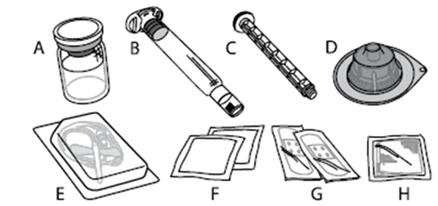
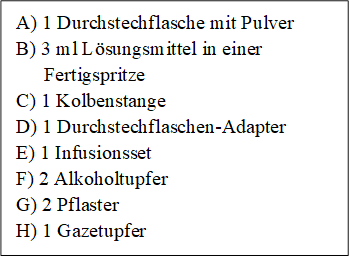
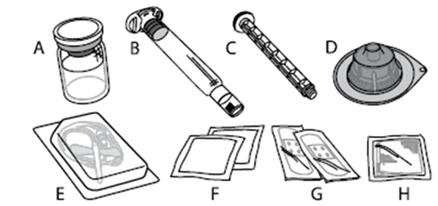
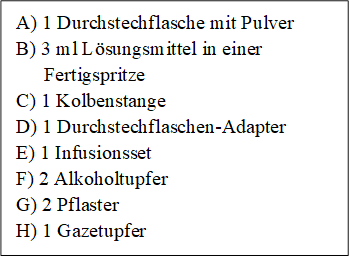

Element: -  <p class="MsoNormal" id="23371dce-f0eb-435f-a907-cf9f3ec2b0ce" style="line-height:normal;page-break-after:avoid">
<table align="left" cellpadding="0" cellspacing="0">
<tr>
<td height="8055" width="53"></td>
<td width="438"></td>
<td width="110"></td>
<td width="350"></td>
</tr>
<tr>
<td height="206"></td>
<td align="left" valign="top"></td>
<td></td>
<td align="left" rowspan="2" valign="top"><img alt="A) 1 Durchstechflasche mit Pulver
B) 3 ml Lösungsmittel in einer Fertigspritze
C) 1 Kolbenstange 
D) 1 Durchstechflaschen-Adapter 
E) 1 Infusionsset
F) 2 Alkoholtupfer
G) 2 Pflaster 
H) 1 Gazetupfer
" height="172" src="" width="233"/></td>
</tr>
<tr>
<td height="52"></td>
</tr>
</table>
</p>
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child:   | 1
  | 1
child
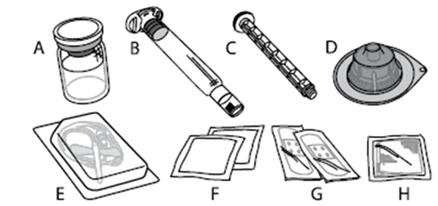
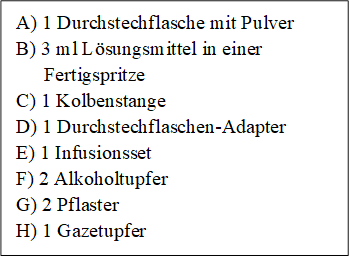

child: Zubereitung: | 12
Zubereitung: | 12
counts 12 12
b perctange in given element is 100.0
Zubereitung: | 12
Element: -  <p class="MsoNormal" id="bb2b2480-7809-47dd-9675-0d1c4458bbff" style="margin-right:-.1pt;line-height:normal;page-break-after:
avoid"><b><span lang="DE">Zubereitung:</span></b></p>
child: Zubereitung: | 12
counts 0 12
u perctange in given element is 0.0
[]
Zubereitung: | 12
Element: -  <p class="MsoNormal" id="bb2b2480-7809-47dd-9675-0d1c4458bbff" style="margin-right:-.1pt;line-height:normal;page-break-after:
avoid"><b><span lang="DE">Zubereitung:</span></b></p>
child: Zubereitung: | 12
counts 0 12
i perctange in given element is 0.0
[]
Zubereitung: | 12
Element: -  <p class="MsoNormal" id="bb2b2480-7809-47dd-9675-0d1c4458bbff" style="margin-right:-.1pt;line-height:normal;page-break-after:
avoid"><b><span lang="DE">Zubereitung:</span></b></p>
child: Zubereitung: | 12
counts 0 12
em perctange in given element is 0.0
[]
Verabreichung (intravenöse Injektion): | 38
Ele

child: SE-112 76 Stockholm, | 20
counts 0 20
u perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="ea0b6eee-e0b2-4340-b0f6-205d940fb855" style="line-height:normal;page-break-after:avoid"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
i perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="ea0b6eee-e0b2-4340-b0f6-205d940fb855" style="line-height:normal;page-break-after:avoid"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
em perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="298662e7-90ed-44ea-bed9-30c723cbcbf2" style="line-height:normal"><span lang="DE">Schweden</span></p>
child: Schweden | 8
counts 0 8
b perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="298662e7-90ed-44ea-bed9-30c723cbcbf2" style="line-height:normal"><span lang="D

child: Datum der letzten Verlängerung der Zulassung: 19.August 2020 | 60
counts 0 60
u perctange in given element is 0.0
[]
Datum der letzten Verlängerung der Zulassung: 19.August 2020 | 60
Element: -  <p class="MsoNormal" id="f06d7164-2c8d-4a41-8f37-fdbb427e9a6e" style="line-height:normal"><span lang="DE">Datum der letzten Verlängerung der Zulassung: 19. August 2020</span></p>
child: Datum der letzten Verlängerung der Zulassung: 19.August 2020 | 60
counts 0 60
i perctange in given element is 0.0
[]
Datum der letzten Verlängerung der Zulassung: 19.August 2020 | 60
Element: -  <p class="MsoNormal" id="f06d7164-2c8d-4a41-8f37-fdbb427e9a6e" style="line-height:normal"><span lang="DE">Datum der letzten Verlängerung der Zulassung: 19. August 2020</span></p>
child: Datum der letzten Verlängerung der Zulassung: 19.August 2020 | 60
counts 0 60
em perctange in given element is 0.0
[]
10. STAND DER INFORMATION | 25
Element: -  <p class="MsoNormal" id="7ae38a17-cf04-4e87-924a-22dddb8564ba" style="

child: B. BEDINGUNGEN ODER EINSCHRÄNKUNGEN FÜR DIE ABGABE UND DEN GEBRAUCH | 67
counts 0 67
i perctange in given element is 0.0
[]
B. BEDINGUNGEN ODER EINSCHRÄNKUNGEN FÜR DIE ABGABE UND DEN GEBRAUCH | 67
Element: -  <p class="MsoNormal" id="c82ce5ce-7f70-4cb6-97f5-db3484e0c106" style="margin-top:0in;margin-right:70.8pt;margin-bottom:
0in;margin-left:85.05pt;margin-bottom:.0001pt;text-indent:-35.4pt;line-height:
normal"><b><span lang="DE">B.        BEDINGUNGEN ODER EINSCHRÄNKUNGEN FÜR DIE ABGABE UND DEN GEBRAUCH</span></b></p>
child: B. BEDINGUNGEN ODER EINSCHRÄNKUNGEN FÜR DIE ABGABE UND DEN GEBRAUCH | 67
counts 0 67
em perctange in given element is 0.0
[]
C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
Element: -  <p class="MsoNormal" id="464dee83-a143-473f-8340-0733ef8e38e7" style="margin-top:0in;margin-right:70.5pt;margin-bottom:
0in;margin-left:85.05pt;margin-bottom:.0001pt;text-indent:-35.4pt;line-height:
normal"><b><span lang="DE">C.        SONST

child: Biogen Inc | 10
counts 0 10
em perctange in given element is 0.0
[]
250 Binney Street | 17
Element: -  <p class="MsoNormal" id="4d19b75a-34c8-4978-bc66-ecefeb9d7ebe" style="line-height:normal"><span lang="EN-GB">250 Binney Street</span></p>
child: 250 Binney Street | 17
counts 0 17
b perctange in given element is 0.0
[]
250 Binney Street | 17
Element: -  <p class="MsoNormal" id="4d19b75a-34c8-4978-bc66-ecefeb9d7ebe" style="line-height:normal"><span lang="EN-GB">250 Binney Street</span></p>
child: 250 Binney Street | 17
counts 0 17
u perctange in given element is 0.0
[]
250 Binney Street | 17
Element: -  <p class="MsoNormal" id="4d19b75a-34c8-4978-bc66-ecefeb9d7ebe" style="line-height:normal"><span lang="EN-GB">250 Binney Street</span></p>
child: 250 Binney Street | 17
counts 0 17
i perctange in given element is 0.0
[]
250 Binney Street | 17
Element: -  <p class="MsoNormal" id="4d19b75a-34c8-4978-bc66-ecefeb9d7ebe" style="line-height:normal"><span lang="EN-GB">250 Binney Street</

child: C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
counts 0 77
u perctange in given element is 0.0
[]
C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
Element: -  <p class="TitleB" id="3972fc72-2561-4b2c-a49b-d81ebd05a2ee" style="page-break-after:avoid"><span lang="DE">C.      SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN</span></p>
child: C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
counts 0 77
i perctange in given element is 0.0
[]
C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
Element: -  <p class="TitleB" id="3972fc72-2561-4b2c-a49b-d81ebd05a2ee" style="page-break-after:avoid"><span lang="DE">C.      SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN</span></p>
child: C. SONSTIGE BEDINGUNGEN UND AUFLAGEN DER GENEHMIGUNG FÜR DAS INVERKEHRBRINGEN | 77
counts 0 77
em perctange in given el

child: Der Inhaber der Genehmigung für das Inverkehrbringen (MAH) führt die notwendigen, im vereinbarten RMP beschriebenen und in Modul1.8.2 der Zulassung dargelegten Pharmakovigilanzaktivitäten und Maßnahmen sowie alle künftigen vereinbarten Aktualisierungen des RMP durch. | 267
counts 0 267
b perctange in given element is 0.0
[]
Der Inhaber der Genehmigung für das Inverkehrbringen (MAH) führt die notwendigen, im vereinbarten RMP beschriebenen und in Modul1.8.2 der Zulassung dargelegten Pharmakovigilanzaktivitäten und Maßnahmen sowie alle künftigen vereinbarten Aktualisierungen des RMP durch. | 267
Element: -  <p class="MsoNormal" id="55037668-4387-43e2-b70e-38bf6b0e5347" style="line-height:normal"><span lang="DE">Der Inhaber der Genehmigung für das Inverkehrbringen (MAH) führt die notwendigen, im vereinbarten RMP beschriebenen und in Modul 1.8.2 der Zulassung dargelegten Pharmakovigilanzaktivitäten und Maßnahmen sowie alle künftigen vereinbarten Aktualisierungen des RMP durch.</span>

counts 0 308
em perctange in given element is 0.0
[]
ANHANGIII | 9
Element: -  <p align="center" class="MsoNormal" id="5da82baa-046e-413c-927b-ab9ddb26d0ff" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG III</span></b></p>
child: ANHANGIII | 9
ANHANGIII | 9
counts 9 9
b perctange in given element is 100.0
ANHANGIII | 9
Element: -  <p align="center" class="MsoNormal" id="5da82baa-046e-413c-927b-ab9ddb26d0ff" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG III</span></b></p>
child: ANHANGIII | 9
counts 0 9
u perctange in given element is 0.0
[]
ANHANGIII | 9
Element: -  <p align="center" class="MsoNormal" id="5da82baa-046e-413c-927b-ab9ddb26d0ff" style="text-align:center;line-height:normal"><b><span lang="DE">ANHANG III</span></b></p>
child: ANHANGIII | 9
counts 0 9
i perctange in given element is 0.0
[]
ANHANGIII | 9
Element: -  <p align="center" class="MsoNormal" id="5da82baa-046e-413c-927b-ab9ddb26d0ff" style="text-align:center;line-heigh

child: (rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
counts 0 55
b perctange in given element is 0.0
[]
(rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
Element: -  <p class="MsoNormal" id="7ce9f0c9-9d67-4b92-aad0-1529b0a20981" style="line-height:normal"><span lang="DE">(rekombinanter Gerinnungsfaktor VIII, Fc‑Fusionsprotein)</span></p>
child: (rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
counts 0 55
u perctange in given element is 0.0
[]
(rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
Element: -  <p class="MsoNormal" id="7ce9f0c9-9d67-4b92-aad0-1529b0a20981" style="line-height:normal"><span lang="DE">(rekombinanter Gerinnungsfaktor VIII, Fc‑Fusionsprotein)</span></p>
child: (rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
counts 0 55
i perctange in given element is 0.0
[]
(rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
Element: -  <p class="MsoNormal" id="7ce9f0c9-9d67-4b92-aad0-1529b0a20981" style="line-h

child: Inhalt: 1Durchstechflasche mit Pulver, 3ml Lösungsmittel in einer Fertigspritze, 1Kolbenstange, 1Durchstechflaschen-Adapter, 1Infusionsset, 2Alkoholtupfer, 2Pflaster, 1Gazetupfer | 178
counts 0 178
i perctange in given element is 0.0
[]
Inhalt: 1Durchstechflasche mit Pulver, 3ml Lösungsmittel in einer Fertigspritze, 1Kolbenstange, 1Durchstechflaschen-Adapter, 1Infusionsset, 2Alkoholtupfer, 2Pflaster, 1Gazetupfer | 178
Element: -  <p class="MsoNormal" id="a7b4056c-443a-4ef6-8e02-c863b31b1d06" style="line-height:normal"><span lang="DE">Inhalt: 1 Durchstechflasche mit Pulver, 3 ml Lösungsmittel in einer Fertigspritze, 1 Kolbenstange, 1 Durchstechflaschen-Adapter, 1 Infusionsset, 2 Alkoholtupfer, 2 Pflaster, 1 Gazetupfer</span></p>
child: Inhalt: 1Durchstechflasche mit Pulver, 3ml Lösungsmittel in einer Fertigspritze, 1Kolbenstange, 1Durchstechflaschen-Adapter, 1Infusionsset, 2Alkoholtupfer, 2Pflaster, 1Gazetupfer | 178
counts 0 178
em perctange in given element is 0.0
[]
5. HINWEIS

child: verwendbar bis | 14
counts 0 14
b perctange in given element is 0.0
[]
verwendbar bis | 14
Element: -  <p class="MsoNormal" id="08629c3c-48f3-4bcb-bdfe-7f407b0ff241" style="line-height:normal"><span lang="DE">verwendbar bis</span></p>
child: verwendbar bis | 14
counts 0 14
u perctange in given element is 0.0
[]
verwendbar bis | 14
Element: -  <p class="MsoNormal" id="08629c3c-48f3-4bcb-bdfe-7f407b0ff241" style="line-height:normal"><span lang="DE">verwendbar bis</span></p>
child: verwendbar bis | 14
counts 0 14
i perctange in given element is 0.0
[]
verwendbar bis | 14
Element: -  <p class="MsoNormal" id="08629c3c-48f3-4bcb-bdfe-7f407b0ff241" style="line-height:normal"><span lang="DE">verwendbar bis</span></p>
child: verwendbar bis | 14
counts 0 14
em perctange in given element is 0.0
[]
Innerhalb von 6Stunden nach der Rekonstitution anwenden. | 56
Element: -  <p class="MsoNormal" id="dcd0d7c0-dd82-415f-a003-a41c7db7ec9d" style="line-height:normal"><span lang="DE">Innerhalb von 6

[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="73ad5af0-142b-4011-a6a5-0418b49a0a1b" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
b perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="73ad5af0-142b-4011-a6a5-0418b49a0a1b" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
u perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="73ad5af0-142b-4011-a6a5-0418b49a0a1b" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
i perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="73ad5af0-142b-4011-a6a5-0418b49a0a1b" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0

15. HINWEISE FÜR DEN GEBRAUCH | 29
Element: -  <p class="MsoNormal" id="ebd29448-30f5-4377-af6f-d9ebfaf4bb0b" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">15.     HINWEISE FÜR DEN GEBRAUCH</span></b></p>
child: 15. HINWEISE FÜR DEN GEBRAUCH | 29
15. HINWEISE FÜR DEN GEBRAUCH | 29
counts 29 29
b perctange in given element is 100.0
15. HINWEISE FÜR DEN GEBRAUCH | 29
Element: -  <p class="MsoNormal" id="ebd29448-30f5-4377-af6f-d9ebfaf4bb0b" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">15.     HINWEISE FÜR DEN GEBRAUCH</span></b></p>
child: 15. HINWEISE FÜR DEN GEBRAUCH | 29
counts 0 29
u perctange in given element is 0.0
[]
15. HINWEISE FÜR DEN GEBRAUCH | 29
Element: -  <p class="MsoNormal" id="ebd29448-30f5-4377-af6f-d9ebfaf4bb0b" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-af

child: Efmoroctocog alfa | 17
counts 0 17
i perctange in given element is 0.0
[]
Efmoroctocog alfa | 17
Element: -  <p class="MsoNormal" id="5c2b90f1-671d-4c84-a353-b801dab253b2" style="line-height:normal"><span lang="DE">Efmoroctocog alfa</span></p>
child: Efmoroctocog alfa | 17
counts 0 17
em perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="bb65bc5d-9339-4fdd-8ce5-92a3ca1639ef" style="line-height:normal"><span lang="DE">rekombinanter Gerinnungsfaktor VIII</span></p>
child: rekombinanter GerinnungsfaktorVIII | 34
counts 0 34
b perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="bb65bc5d-9339-4fdd-8ce5-92a3ca1639ef" style="line-height:normal"><span lang="DE">rekombinanter Gerinnungsfaktor VIII</span></p>
child: rekombinanter GerinnungsfaktorVIII | 34
counts 0 34
u perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class=

Element: -  <p class="MsoNormal" id="d2950e39-dc83-4c20-9ab2-49bccde3cefd" style="margin-right:5.65pt;line-height:normal;page-break-after:
avoid"><span lang="DE">250 I.E.</span></p>
child: 250I.E. | 7
counts 0 7
u perctange in given element is 0.0
[]
250I.E. | 7
Element: -  <p class="MsoNormal" id="d2950e39-dc83-4c20-9ab2-49bccde3cefd" style="margin-right:5.65pt;line-height:normal;page-break-after:
avoid"><span lang="DE">250 I.E.</span></p>
child: 250I.E. | 7
counts 0 7
i perctange in given element is 0.0
[]
250I.E. | 7
Element: -  <p class="MsoNormal" id="d2950e39-dc83-4c20-9ab2-49bccde3cefd" style="margin-right:5.65pt;line-height:normal;page-break-after:
avoid"><span lang="DE">250 I.E.</span></p>
child: 250I.E. | 7
counts 0 7
em perctange in given element is 0.0
[]
6. WEITERE ANGABEN | 18
Element: -  <p class="MsoNormal" id="d550cdf9-ab46-417c-9751-d45ca5e2e126" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><spa

i perctange in given element is 0.0
[]
Efmoroctocog alfa | 17
Element: -  <p class="MsoNormal" id="5076050a-82c1-49b5-9b75-fa589f450a98" style="line-height:normal"><span lang="DE">Efmoroctocog alfa</span></p>
child: Efmoroctocog alfa | 17
counts 0 17
em perctange in given element is 0.0
[]
(rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
Element: -  <p class="MsoNormal" id="19117ede-166d-479a-9002-a305e1839629" style="line-height:normal"><span lang="DE">(rekombinanter Gerinnungsfaktor VIII, Fc‑Fusionsprotein)</span></p>
child: (rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
counts 0 55
b perctange in given element is 0.0
[]
(rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
Element: -  <p class="MsoNormal" id="19117ede-166d-479a-9002-a305e1839629" style="line-height:normal"><span lang="DE">(rekombinanter Gerinnungsfaktor VIII, Fc‑Fusionsprotein)</span></p>
child: (rekombinanter GerinnungsfaktorVIII, Fc‑Fusionsprotein) | 55
counts 0 55
u perctange in g

5. HINWEISE ZUR UND ART(EN) DER ANWENDUNG | 41
Element: -  <p class="MsoNormal" id="c570265a-2cf8-4626-be04-0b10f715edce" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">5.       HINWEISE ZUR UND ART(EN) DER ANWENDUNG</span></b></p>
child: 5. HINWEISE ZUR UND ART(EN) DER ANWENDUNG | 41
counts 0 41
em perctange in given element is 0.0
[]
Intravenöse Anwendung, nach Rekonstitution. | 43
Element: -  <p class="MsoNormal" id="90d2a7b4-8fd6-4c01-a60c-f806033b394b" style="line-height:normal"><span lang="DE">Intravenöse Anwendung, nach Rekonstitution.</span></p>
child: Intravenöse Anwendung, nach Rekonstitution. | 43
counts 0 43
b perctange in given element is 0.0
[]
Intravenöse Anwendung, nach Rekonstitution. | 43
Element: -  <p class="MsoNormal" id="90d2a7b4-8fd6-4c01-a60c-f806033b394b" style="line-height:normal"><span lang="DE">Intravenöse Anwendung, nach Rekonstitution.</span></p>
child: Intravenöse Anwe

Arzneimittel für Kinder unzugänglich aufbewahren. | 49
Element: -  <p class="MsoNormal" id="63646c49-84b9-48aa-ac36-daa1ba1afda4" style="line-height:normal"><span lang="DE">Arzneimittel für Kinder unzugänglich aufbewahren.</span></p>
child: Arzneimittel für Kinder unzugänglich aufbewahren. | 49
counts 0 49
b perctange in given element is 0.0
[]
Arzneimittel für Kinder unzugänglich aufbewahren. | 49
Element: -  <p class="MsoNormal" id="63646c49-84b9-48aa-ac36-daa1ba1afda4" style="line-height:normal"><span lang="DE">Arzneimittel für Kinder unzugänglich aufbewahren.</span></p>
child: Arzneimittel für Kinder unzugänglich aufbewahren. | 49
counts 0 49
u perctange in given element is 0.0
[]
Arzneimittel für Kinder unzugänglich aufbewahren. | 49
Element: -  <p class="MsoNormal" id="63646c49-84b9-48aa-ac36-daa1ba1afda4" style="line-height:normal"><span lang="DE">Arzneimittel für Kinder unzugänglich aufbewahren.</span></p>
child: Arzneimittel für Kinder unzugänglich aufbewahren. | 49
counts 0 4

child: Im Kühlschrank lagern. | 22
counts 0 22
i perctange in given element is 0.0
[]
Im Kühlschrank lagern. | 22
Element: -  <p class="MsoNormal" id="83a20cdf-d437-4f8a-91d7-b5f315c88955" style="line-height:normal"><span lang="DE">Im Kühlschrank lagern.</span></p>
child: Im Kühlschrank lagern. | 22
counts 0 22
em perctange in given element is 0.0
[]
Nicht einfrieren. | 17
Element: -  <p class="MsoNormal" id="3288df78-d159-485d-b72d-5f1f222a456c" style="line-height:normal"><span lang="DE">Nicht einfrieren.</span></p>
child: Nicht einfrieren. | 17
counts 0 17
b perctange in given element is 0.0
[]
Nicht einfrieren. | 17
Element: -  <p class="MsoNormal" id="3288df78-d159-485d-b72d-5f1f222a456c" style="line-height:normal"><span lang="DE">Nicht einfrieren.</span></p>
child: Nicht einfrieren. | 17
counts 0 17
u perctange in given element is 0.0
[]
Nicht einfrieren. | 17
Element: -  <p class="MsoNormal" id="3288df78-d159-485d-b72d-5f1f222a456c" style="line-height:normal"><span lang="DE">Nich

counts 0 56
em perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
Element: -  <p class="MsoNormal" id="d310da3c-74c2-4554-9eba-e67971c581bc" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
b perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
Element: -  <p class="MsoNormal" id="d310da3c-74c2-4554-9eba-e67971c581bc" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
u perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
Element: -  <p class="MsoNormal" id="d310da3c-74c2-4554-9eba-e67971c581bc" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
i perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
El

14. VERKAUFSABGRENZUNG | 22
Element: -  <p class="MsoNormal" id="8d95debe-1191-4bb4-a0d7-d0e2488d92a4" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">14.     VERKAUFSABGRENZUNG</span></b></p>
child: 14. VERKAUFSABGRENZUNG | 22
counts 0 22
em perctange in given element is 0.0
[]
15. HINWEISE FÜR DEN GEBRAUCH | 29
Element: -  <p class="MsoNormal" id="8ed4055e-c3eb-4c04-b157-475edd65df95" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">15.     HINWEISE FÜR DEN GEBRAUCH</span></b></p>
child: 15. HINWEISE FÜR DEN GEBRAUCH | 29
15. HINWEISE FÜR DEN GEBRAUCH | 29
counts 29 29
b perctange in given element is 100.0
15. HINWEISE FÜR DEN GEBRAUCH | 29
Element: -  <p class="MsoNormal" id="8ed4055e-c3eb-4c04-b157-475edd65df95" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:non

child: 1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
counts 0 60
i perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
Element: -  <p class="MsoNormal" id="d91e72e3-e451-4535-a920-dd1421a43542" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
counts 0 60
em perctange in given element is 0.0
[]
ELOCTA 500I.E. Pulver zur Herstellung einer Injektionslösung | 60
Element: -  <p class="MsoNormal" id="b8afe47a-d77a-4584-8116-69282779e887" style="line-height:normal"><span lang="DE">ELOCTA 500 I.E. Pulver zur Herstellung einer Injektionslösung</span></p>
child: ELOCTA 500I.E. Pulver zur Herstellung einer Injektionslösung | 60
counts 0 60
b perctange in given element is 0.0
[]
ELOCTA 500I.

child: 5. INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN | 46
counts 0 46
em perctange in given element is 0.0
[]
500I.E. | 7
Element: -  <p class="MsoNormal" id="3cdf4220-978d-4ca5-b20e-9c9b75caefe1" style="margin-right:5.65pt;line-height:normal"><span lang="DE">500 I.E.</span></p>
child: 500I.E. | 7
counts 0 7
b perctange in given element is 0.0
[]
500I.E. | 7
Element: -  <p class="MsoNormal" id="3cdf4220-978d-4ca5-b20e-9c9b75caefe1" style="margin-right:5.65pt;line-height:normal"><span lang="DE">500 I.E.</span></p>
child: 500I.E. | 7
counts 0 7
u perctange in given element is 0.0
[]
500I.E. | 7
Element: -  <p class="MsoNormal" id="3cdf4220-978d-4ca5-b20e-9c9b75caefe1" style="margin-right:5.65pt;line-height:normal"><span lang="DE">500 I.E.</span></p>
child: 500I.E. | 7
counts 0 7
i perctange in given element is 0.0
[]
500I.E. | 7
Element: -  <p class="MsoNormal" id="3cdf4220-978d-4ca5-b20e-9c9b75caefe1" style="margin-right:5.65pt;line-height:normal"><span lang="DE">500 I.E.</span></p>
ch

child: 1Durchstechflasche mit Pulver enthält  | 38
child: 750I.E. Efmoroctocog alfa (ca. 250I.E./ml nach Rekonstitution), | 63
counts 0 101
u perctange in given element is 0.0
[]
1Durchstechflasche mit Pulver enthält 750I.E. Efmoroctocog alfa (ca. 250I.E./ml nach Rekonstitution), | 101
Element: -  <p class="MsoNormal" id="94d7b55a-9b8d-4b5e-bea7-5b8d17b96d3d" style="line-height:normal"><span lang="DE">1 Durchstechflasche mit Pulver enthält </span><span lang="DE">750 I.E. Efmoroctocog alfa (ca. 250 I.E./ml nach Rekonstitution),</span></p>
child: 1Durchstechflasche mit Pulver enthält  | 38
child: 750I.E. Efmoroctocog alfa (ca. 250I.E./ml nach Rekonstitution), | 63
counts 0 101
i perctange in given element is 0.0
[]
1Durchstechflasche mit Pulver enthält 750I.E. Efmoroctocog alfa (ca. 250I.E./ml nach Rekonstitution), | 101
Element: -  <p class="MsoNormal" id="94d7b55a-9b8d-4b5e-bea7-5b8d17b96d3d" style="line-height:normal"><span lang="DE">1 Durchstechflasche mit Pulver enthält </span><span

counts 0 63
b perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
Element: -  <p class="MsoNormal" id="25187388-f3ff-4452-8aae-789ab90bc41b" style="line-height:normal;page-break-after:avoid"><span lang="DE" style="color:black;background:#D9D9D9">Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
counts 0 63
u perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
Element: -  <p class="MsoNormal" id="25187388-f3ff-4452-8aae-789ab90bc41b" style="line-height:normal;page-break-after:avoid"><span lang="DE" style="color:black;background:#D9D9D9">Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
counts 0 63
i perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer 

child: QR-Code einfügen | 16
child:  + | 2
child: http://www.elocta-instructions.com | 34
counts 0 52
b perctange in given element is 0.0
[]
QR-Code einfügen +http://www.elocta-instructions.com | 52
Element: -  <p class="MsoNormal" id="872181f0-d41e-467a-9ec6-dd291ee7784b" style="line-height:normal"><span lang="DE" style="background:
lightgrey">QR-Code einfügen</span><span lang="DE" style="color:black;background:
#BFBFBF"> +</span><span lang="EN-GB"><a href="http://www.elocta-instructions.com/"><span lang="DE" style="color:#0000CC">http://www.elocta-instructions.com</span></a></span></p>
child: QR-Code einfügen | 16
child:  + | 2
child: http://www.elocta-instructions.com | 34
counts 0 52
u perctange in given element is 0.0
[]
QR-Code einfügen +http://www.elocta-instructions.com | 52
Element: -  <p class="MsoNormal" id="872181f0-d41e-467a-9ec6-dd291ee7784b" style="line-height:normal"><span lang="DE" style="background:
lightgrey">QR-Code einfügen</span><span lang="DE" style="color:black;

counts 0 17
u perctange in given element is 0.0
[]
Nicht einfrieren. | 17
Element: -  <p class="MsoNormal" id="b5508003-c39e-4c6c-83b4-37d966d66a98" style="line-height:normal"><span lang="DE">Nicht einfrieren.</span></p>
child: Nicht einfrieren. | 17
counts 0 17
i perctange in given element is 0.0
[]
Nicht einfrieren. | 17
Element: -  <p class="MsoNormal" id="b5508003-c39e-4c6c-83b4-37d966d66a98" style="line-height:normal"><span lang="DE">Nicht einfrieren.</span></p>
child: Nicht einfrieren. | 17
counts 0 17
em perctange in given element is 0.0
[]
Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
Element: -  <p class="MsoNormal" id="fc056aa6-5531-4556-bf72-6da8811c2318" style="line-height:normal"><span lang="DE">Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen.</span></p>
child: Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
counts 0 83
b perctange in given element is 0.0


SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="40f8b58e-aaaf-4455-80a5-15c81451e5f0" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
em perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="2c475949-9370-4add-85ef-7d9083b60a5d" style="line-height:normal"><span lang="DE">Schweden</span></p>
child: Schweden | 8
counts 0 8
b perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="2c475949-9370-4add-85ef-7d9083b60a5d" style="line-height:normal"><span lang="DE">Schweden</span></p>
child: Schweden | 8
counts 0 8
u perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="2c475949-9370-4add-85ef-7d9083b60a5d" style="line-height:normal"><span lang="DE">Schweden</span></p>
child: Schweden | 8
counts 0 8
i perctange in given element is 0.0
[]
Schweden | 8
Element: -  <p class="MsoNormal" id="2c475949-9370-4add-85ef-7d

counts 0 9
b perctange in given element is 0.0
[]
ELOCTA750 | 9
Element: -  <p class="MsoNormal" id="e6f55aeb-6b05-4ef4-aa81-5dd768d3df9e" style="line-height:normal"><span lang="DE">ELOCTA 750</span></p>
child: ELOCTA750 | 9
counts 0 9
u perctange in given element is 0.0
[]
ELOCTA750 | 9
Element: -  <p class="MsoNormal" id="e6f55aeb-6b05-4ef4-aa81-5dd768d3df9e" style="line-height:normal"><span lang="DE">ELOCTA 750</span></p>
child: ELOCTA750 | 9
counts 0 9
i perctange in given element is 0.0
[]
ELOCTA750 | 9
Element: -  <p class="MsoNormal" id="e6f55aeb-6b05-4ef4-aa81-5dd768d3df9e" style="line-height:normal"><span lang="DE">ELOCTA 750</span></p>
child: ELOCTA750 | 9
counts 0 9
em perctange in given element is 0.0
[]
17. INDIVIDUELLES ERKENNUNGSMERKMAL – 2D-BARCODE | 48
Element: -  <p class="MsoNormal" id="07cc10d3-23ca-43b0-936c-2fa0a5d04acc" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">17.     IN

counts 0 60
u perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
Element: -  <p class="MsoNormal" id="2979bd3c-96ae-4b60-8eb4-cdde0a964983" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
counts 0 60
i perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
Element: -  <p class="MsoNormal" id="2979bd3c-96ae-4b60-8eb4-cdde0a964983" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS SOWIE ART(EN) DER ANWENDUNG | 60
counts 0 60
em perctange in given el

normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">5.       INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN</span></b></p>
child: 5. INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN | 46
counts 0 46
i perctange in given element is 0.0
[]
5. INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN | 46
Element: -  <p class="MsoNormal" id="6d0ebc4d-e5d9-4d15-bd40-173d6ddcd273" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">5.       INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN</span></b></p>
child: 5. INHALT NACH GEWICHT, VOLUMEN ODER EINHEITEN | 46
counts 0 46
em perctange in given element is 0.0
[]
750I.E. | 7
Element: -  <p class="MsoNormal" id="b641f14a-71cb-4da3-ad03-346827ac4dcf" style="margin-right:5.65pt;line-height:normal"><span lang="DE">750 I.E.</span></p>
child: 750I.E. | 7
counts 0 7
b perctange in given element is 0.0
[]
750I.E. | 7
Element: -  <p class="MsoNormal" id="b641f14a-71cb-4da3-

child: 1Durchstechflasche mit Pulver enthält  | 38
child: 1000I.E. Efmoroctocog alfa (ca. 333I.E./ml nach Rekonstitution), | 64
counts 0 102
u perctange in given element is 0.0
[]
1Durchstechflasche mit Pulver enthält 1000I.E. Efmoroctocog alfa (ca. 333I.E./ml nach Rekonstitution), | 102
Element: -  <p class="MsoNormal" id="84db7487-6205-4488-a4a4-066cbd05868e" style="line-height:normal"><span lang="DE">1 Durchstechflasche mit Pulver enthält </span><span lang="DE">1000 I.E. Efmoroctocog alfa (ca. 333 I.E./ml nach Rekonstitution),</span></p>
child: 1Durchstechflasche mit Pulver enthält  | 38
child: 1000I.E. Efmoroctocog alfa (ca. 333I.E./ml nach Rekonstitution), | 64
counts 0 102
i perctange in given element is 0.0
[]
1Durchstechflasche mit Pulver enthält 1000I.E. Efmoroctocog alfa (ca. 333I.E./ml nach Rekonstitution), | 102
Element: -  <p class="MsoNormal" id="84db7487-6205-4488-a4a4-066cbd05868e" style="line-height:normal"><span lang="DE">1 Durchstechflasche mit Pulver enthält </span>

counts 0 63
b perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
Element: -  <p class="MsoNormal" id="3b1e391c-2fed-4a44-998d-a9bbd7bba09a" style="line-height:normal;page-break-after:avoid"><span lang="DE" style="color:black;background:#D9D9D9">Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
counts 0 63
u perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
Element: -  <p class="MsoNormal" id="3b1e391c-2fed-4a44-998d-a9bbd7bba09a" style="line-height:normal;page-break-after:avoid"><span lang="DE" style="color:black;background:#D9D9D9">Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 63
counts 0 63
i perctange in given element is 0.0
[]
Pulver und Lösungsmittel zur Herstellung einer 

child: Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
counts 0 163
b perctange in given element is 0.0
[]
Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
Element: -  <p class="MsoNormal" id="725271bc-30c7-4109-88a4-81ece43d689b" style="line-height:normal"><span lang="DE">Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden</span></p>
child: Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
counts 0 163
u perctange in given element is 0.0
[]
Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Abl

9. BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG | 53
Element: -  <p class="MsoNormal" id="6d622a13-8dfd-4382-8f59-5413304eca5e" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">9.       BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG</span></b></p>
child: 9. BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG | 53
9. BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG | 53
counts 53 53
b perctange in given element is 100.0
9. BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG | 53
Element: -  <p class="MsoNormal" id="6d622a13-8dfd-4382-8f59-5413304eca5e" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">9.       BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG</span></b></p>
child: 9. BESONDERE VORSICHTSMASSNAHMEN FÜR DIE AUFBEWAHRUNG | 53
counts 0 53
u perctange in given element is 0.0
[]
9. BESONDERE VORSIC

Element: -  <p class="MsoNormal" id="588f7ca9-98f7-4901-a6b1-4a27adde68a1" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
u perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
Element: -  <p class="MsoNormal" id="588f7ca9-98f7-4901-a6b1-4a27adde68a1" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
i perctange in given element is 0.0
[]
Swedish Orphan Biovitrum AB (publ) | 34
Element: -  <p class="MsoNormal" id="588f7ca9-98f7-4901-a6b1-4a27adde68a1" style="line-height:normal"><span lang="DE">Swedish Orphan Biovitrum AB (publ)</span></p>
child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
em perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="6ac8b59c-8ccd-4129-9271-92314d1ba3e7" style="line-height:normal"><span

normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">16.     ANGABEN IN BLINDENSCHRIFT</span></b></p>
child: 16. ANGABEN IN BLINDENSCHRIFT | 29
16. ANGABEN IN BLINDENSCHRIFT | 29
counts 29 29
b perctange in given element is 100.0
16. ANGABEN IN BLINDENSCHRIFT | 29
Element: -  <p class="MsoNormal" id="12f50b2c-8973-41c3-a97e-03ad90225da7" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">16.     ANGABEN IN BLINDENSCHRIFT</span></b></p>
child: 16. ANGABEN IN BLINDENSCHRIFT | 29
counts 0 29
u perctange in given element is 0.0
[]
16. ANGABEN IN BLINDENSCHRIFT | 29
Element: -  <p class="MsoNormal" id="12f50b2c-8973-41c3-a97e-03ad90225da7" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">16.     ANGABEN IN BLINDENSCHRIFT</span></b></p>
child: 16. ANGABEN IN BLINDENSCHRIFT | 29
counts 0 29
i perctange in

rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="a6e17357-783a-4cba-9da0-1adf75dcab17" style="line-height:normal"><span lang="DE">rekombinanter Gerinnungsfaktor VIII</span></p>
child: rekombinanter GerinnungsfaktorVIII | 34
counts 0 34
b perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="a6e17357-783a-4cba-9da0-1adf75dcab17" style="line-height:normal"><span lang="DE">rekombinanter Gerinnungsfaktor VIII</span></p>
child: rekombinanter GerinnungsfaktorVIII | 34
counts 0 34
u perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="a6e17357-783a-4cba-9da0-1adf75dcab17" style="line-height:normal"><span lang="DE">rekombinanter Gerinnungsfaktor VIII</span></p>
child: rekombinanter GerinnungsfaktorVIII | 34
counts 0 34
i perctange in given element is 0.0
[]
rekombinanter GerinnungsfaktorVIII | 34
Element: -  <p class="MsoNormal" id="a6e17357-783a-

Element: -  <p class="MsoNormal" id="2ebac679-4071-4ed6-989e-e30c6de7272c" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS | 32
counts 0 32
i perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS | 32
Element: -  <p class="MsoNormal" id="2ebac679-4071-4ed6-989e-e30c6de7272c" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS | 32
counts 0 32
em perctange in given element is 0.0
[]
ELOCTA 1500I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="dfdf85b0-f7ea-4774-9464-2ca655d12dfd" style="line-height:normal"><span lang="DE">ELOCTA 1500 I.E. Pulver und Lösungsmit

child: Lösungsmittel: Wasser für Injektionszwecke | 42
counts 0 42
em perctange in given element is 0.0
[]
4. DARREICHUNGSFORM UND INHALT | 30
Element: -  <p class="MsoNormal" id="4a4322f0-541b-41ff-81ef-582e7cd90acd" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">4.       DARREICHUNGSFORM UND INHALT</span></b></p>
child: 4. DARREICHUNGSFORM UND INHALT | 30
4. DARREICHUNGSFORM UND INHALT | 30
counts 30 30
b perctange in given element is 100.0
4. DARREICHUNGSFORM UND INHALT | 30
Element: -  <p class="MsoNormal" id="4a4322f0-541b-41ff-81ef-582e7cd90acd" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">4.       DARREICHUNGSFORM UND INHALT</span></b></p>
child: 4. DARREICHUNGSFORM UND INHALT | 30
counts 0 30
u perctange in given element is 0.0
[]
4. DARREICHUNGSFORM UND INHALT | 30
Element: -  <p class="MsoNormal" id="

child: Intravenöse Anwendung, nach Rekonstitution. | 43
counts 0 43
u perctange in given element is 0.0
[]
Intravenöse Anwendung, nach Rekonstitution. | 43
Element: -  <p class="MsoNormal" id="85eb3e38-f512-47e6-b7e8-5b4c3ce7fc2e" style="line-height:normal"><span lang="DE">Intravenöse Anwendung, nach Rekonstitution.</span></p>
child: Intravenöse Anwendung, nach Rekonstitution. | 43
counts 0 43
i perctange in given element is 0.0
[]
Intravenöse Anwendung, nach Rekonstitution. | 43
Element: -  <p class="MsoNormal" id="85eb3e38-f512-47e6-b7e8-5b4c3ce7fc2e" style="line-height:normal"><span lang="DE">Intravenöse Anwendung, nach Rekonstitution.</span></p>
child: Intravenöse Anwendung, nach Rekonstitution. | 43
counts 0 43
em perctange in given element is 0.0
[]
Packungsbeilage beachten. | 25
Element: -  <p class="MsoNormal" id="2a5241b5-9f0e-49d4-8f65-ec3dd1e8cea8" style="line-height:normal"><span lang="DE">Packungsbeilage beachten.</span></p>
child: Packungsbeilage beachten. | 25
counts 0 2

i perctange in given element is 0.0
[]
verwendbar bis | 14
Element: -  <p class="MsoNormal" id="cdae976d-f40d-43d4-a394-c27c4e7550aa" style="line-height:normal"><span lang="DE">verwendbar bis</span></p>
child: verwendbar bis | 14
counts 0 14
em perctange in given element is 0.0
[]
Innerhalb von 6Stunden nach der Rekonstitution anwenden. | 56
Element: -  <p class="MsoNormal" id="27bb9487-d994-46d6-ac23-acc21eeceee3" style="line-height:normal"><span lang="DE">Innerhalb von 6 Stunden nach der Rekonstitution anwenden.</span></p>
child: Innerhalb von 6Stunden nach der Rekonstitution anwenden. | 56
counts 0 56
b perctange in given element is 0.0
[]
Innerhalb von 6Stunden nach der Rekonstitution anwenden. | 56
Element: -  <p class="MsoNormal" id="27bb9487-d994-46d6-ac23-acc21eeceee3" style="line-height:normal"><span lang="DE">Innerhalb von 6 Stunden nach der Rekonstitution anwenden.</span></p>
child: Innerhalb von 6Stunden nach der Rekonstitution anwenden. | 56
counts 0 56
u perctange in give

child: Swedish Orphan Biovitrum AB (publ) | 34
counts 0 34
em perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="5cf83c30-b62a-4523-8c53-9aa88a455606" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
b perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="5cf83c30-b62a-4523-8c53-9aa88a455606" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
u perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="5cf83c30-b62a-4523-8c53-9aa88a455606" style="line-height:normal"><span lang="DE">SE-112 76 Stockholm,</span></p>
child: SE-112 76 Stockholm, | 20
counts 0 20
i perctange in given element is 0.0
[]
SE-112 76 Stockholm, | 20
Element: -  <p class="MsoNormal" id="5cf83c30-b62a-4523-8c53-9aa88a455606" style="line-height:n

i perctange in given element is 0.0
[]
2D-Barcode mit individuellem Erkennungsmerkmal. | 47
Element: -  <p class="MsoNormal" id="e8285c70-d16f-4163-a943-922a3d743ab2" style="line-height:normal"><span lang="DE" style="color:black;
background:#D9D9D9">2D-Barcode mit individuellem Erkennungsmerkmal.</span></p>
child: 2D-Barcode mit individuellem Erkennungsmerkmal. | 47
counts 0 47
em perctange in given element is 0.0
[]
18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT | 66
Element: -  <p class="MsoNormal" id="263d8bc1-7127-4fba-918d-22b0e17f7a35" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">18.     INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT</span></b></p>
child: 18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT | 66
18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT | 66
counts 66 66
b perctange in given element is 100.0
18. INDIV

counts 25 25
b perctange in given element is 100.0
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="2c2f1af1-a9a3-4e1b-a21b-efd68f92c949" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">2.       HINWEISE ZUR ANWENDUNG</span></b></p>
child: 2. HINWEISE ZUR ANWENDUNG | 25
counts 0 25
u perctange in given element is 0.0
[]
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="2c2f1af1-a9a3-4e1b-a21b-efd68f92c949" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">2.       HINWEISE ZUR ANWENDUNG</span></b></p>
child: 2. HINWEISE ZUR ANWENDUNG | 25
counts 0 25
i perctange in given element is 0.0
[]
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="2c2f1af1-a9a3-4e1b-a21b-efd68f92c949" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoi

child: 1. BEZEICHNUNG DES ARZNEIMITTELS | 32
1. BEZEICHNUNG DES ARZNEIMITTELS | 32
counts 32 32
b perctange in given element is 100.0
1. BEZEICHNUNG DES ARZNEIMITTELS | 32
Element: -  <p class="MsoNormal" id="a095cbc8-1d2c-4166-8197-6a230f402561" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS | 32
counts 0 32
u perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS | 32
Element: -  <p class="MsoNormal" id="a095cbc8-1d2c-4166-8197-6a230f402561" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">1.       BEZEICHNUNG DES ARZNEIMITTELS</span></b></p>
child: 1. BEZEICHNUNG DES ARZNEIMITTELS | 32
counts 0 32
i perctange in given element is 0.0
[]
1. BEZEICHNUNG DES ARZNEIMITTELS | 32
Element: -  <p class="MsoNormal"

child: 1Durchstechflasche mit Pulver enthält  | 38
child: 2000I.E. Efmoroctocog alfa (ca. 667I.E./ml nach Rekonstitution), | 64
counts 0 102
i perctange in given element is 0.0
[]
1Durchstechflasche mit Pulver enthält 2000I.E. Efmoroctocog alfa (ca. 667I.E./ml nach Rekonstitution), | 102
Element: -  <p class="MsoNormal" id="6abf7925-9149-4a0f-a567-5c0494769b0c" style="line-height:normal"><span lang="DE">1 Durchstechflasche mit Pulver enthält </span><span lang="DE">2000 I.E. Efmoroctocog alfa (ca. 667 I.E./ml nach Rekonstitution),</span></p>
child: 1Durchstechflasche mit Pulver enthält  | 38
child: 2000I.E. Efmoroctocog alfa (ca. 667I.E./ml nach Rekonstitution), | 64
counts 0 102
em perctange in given element is 0.0
[]
3. SONSTIGE BESTANDTEILE | 24
Element: -  <p class="MsoNormal" id="24cd9288-726c-4241-9873-2195b8bc6748" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">3.       SONSTIGE BESTANDTEILE</

child: Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
counts 0 163
b perctange in given element is 0.0
[]
Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
Element: -  <p class="MsoNormal" id="f8b0abb2-62ad-49b8-bf42-54a7bf09fa4d" style="line-height:normal"><span lang="DE">Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden</span></p>
child: Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Ablesen des QR‑Codes mit einem Smartphone sowie über die Internetseite abgerufen werden | 163
counts 0 163
u perctange in given element is 0.0
[]
Ein Video mit Hinweisen zur Zubereitung und Anwendung von ELOCTA kann durch Abl

child: 7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
counts 43 43
b perctange in given element is 100.0
7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
Element: -  <p class="MsoNormal" id="810ec03a-2e8d-4e2e-ab0f-7e073e0699e9" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">7.       WEITERE WARNHINWEISE, FALLS ERFORDERLICH</span></b></p>
child: 7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
counts 0 43
u perctange in given element is 0.0
[]
7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
Element: -  <p class="MsoNormal" id="810ec03a-2e8d-4e2e-ab0f-7e073e0699e9" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">7.       WEITERE WARNHINWEISE, FALLS ERFORDERLICH</span></b></p>
child: 7. WEITERE WARNHINWEISE, FALLS ERFORDERLICH | 43
counts 0 43
i perctange in given 

Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
Element: -  <p class="MsoNormal" id="6932d2b3-2b38-49c5-b445-b17129b1757b" style="line-height:normal"><span lang="DE">Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen.</span></p>
child: Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
counts 0 83
b perctange in given element is 0.0
[]
Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
Element: -  <p class="MsoNormal" id="6932d2b3-2b38-49c5-b445-b17129b1757b" style="line-height:normal"><span lang="DE">Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen.</span></p>
child: Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
counts 0 83
u perctange in given element is 0.0
[]
Die Durchstechflasche im Umkarton aufbewahren, um den Inhalt vor Licht zu schützen. | 83
Element: -  <

child: EU/1/15/1046/006 | 16
counts 0 16
u perctange in given element is 0.0
[]
EU/1/15/1046/006 | 16
Element: -  <p class="MsoNormal" id="b243bc16-26ca-4d6e-8169-d2fb939f5c94" style="line-height:normal"><span lang="DE">EU/1/15/1046/006</span></p>
child: EU/1/15/1046/006 | 16
counts 0 16
i perctange in given element is 0.0
[]
EU/1/15/1046/006 | 16
Element: -  <p class="MsoNormal" id="b243bc16-26ca-4d6e-8169-d2fb939f5c94" style="line-height:normal"><span lang="DE">EU/1/15/1046/006</span></p>
child: EU/1/15/1046/006 | 16
counts 0 16
em perctange in given element is 0.0
[]
13. CHARGENBEZEICHNUNG | 22
Element: -  <p class="MsoNormal" id="b1a179df-fe8e-45e3-82e1-49ebee569769" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">13.     CHARGENBEZEICHNUNG</span></b></p>
child: 13. CHARGENBEZEICHNUNG | 22
13. CHARGENBEZEICHNUNG | 22
counts 22 22
b perctange in given element is 100.0
13. CHARGENBEZEICHNUNG | 22
E

child: 2D-Barcode mit individuellem Erkennungsmerkmal. | 47
counts 0 47
i perctange in given element is 0.0
[]
2D-Barcode mit individuellem Erkennungsmerkmal. | 47
Element: -  <p class="MsoNormal" id="a7e7a470-5268-45ce-abb8-bc2442c6b80f" style="line-height:normal"><span lang="DE" style="color:black;
background:#D9D9D9">2D-Barcode mit individuellem Erkennungsmerkmal.</span></p>
child: 2D-Barcode mit individuellem Erkennungsmerkmal. | 47
counts 0 47
em perctange in given element is 0.0
[]
18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT | 66
Element: -  <p class="MsoNormal" id="3a2fd977-839f-4d06-b0b7-c6d30dc9ba04" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">18.     INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT</span></b></p>
child: 18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES FORMAT | 66
18. INDIVIDUELLES ERKENNUNGSMERKMAL – VOM MENSCHEN LESBARES 

child: i.v. | 4
counts 0 4
em perctange in given element is 0.0
[]
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="49dc38a4-952d-4d9d-b74c-9001393759cf" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">2.       HINWEISE ZUR ANWENDUNG</span></b></p>
child: 2. HINWEISE ZUR ANWENDUNG | 25
2. HINWEISE ZUR ANWENDUNG | 25
counts 25 25
b perctange in given element is 100.0
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="49dc38a4-952d-4d9d-b74c-9001393759cf" style="margin-left:28.35pt;text-indent:-28.35pt;line-height:
normal;page-break-after:avoid;border:none;padding:0in"><b><span lang="DE">2.       HINWEISE ZUR ANWENDUNG</span></b></p>
child: 2. HINWEISE ZUR ANWENDUNG | 25
counts 0 25
u perctange in given element is 0.0
[]
2. HINWEISE ZUR ANWENDUNG | 25
Element: -  <p class="MsoNormal" id="49dc38a4-952d-4d9d-b74c-9001393759cf" style="margin-left:28.35pt;text-indent:-28

ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
Element: -  <p class="MsoNormal" id="44f12eed-6d77-4b96-9615-61229fc19e9b" style="line-height:normal"><span lang="DE">ELOCTA 3000 I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung</span></p>
child: ELOCTA 3000I.E. Pulver und Lösungsmittel zur Herstellung einer Injektionslösung | 79
counts 0 79
em perctange in given element is 0.0
[]
Efmoroctocog alfa | 17
Element: -  <p class="MsoNormal" id="683e2cff-a0ca-4b0e-b724-f2d5fd74d01a" style="line-height:normal"><span lang="DE">Efmoroctocog alfa</span></p>
child: Efmoroctocog alfa | 17
counts 0 17
b perctange in given element is 0.0
[]
Efmoroctocog alfa | 17
Element: -  <p class="MsoNormal" id="683e2cff-a0ca-4b0e-b724-f2d5fd74d01a" style="line-height:normal"><span lang="DE">Efmoroctocog alfa</span></p>
child: Efmoroctocog alfa | 17
counts 0 17
u perctange in given element is 0.0
[]
Efmoroctocog alfa | 17
Element: -  <p class="MsoNormal" id=

In [ ]:
parseDocument(controlFolderPath,
              outputFolderPath,
              htmlFileName,
              fileNameQrd,
              fileNameMatchRuleBook,
              fileNameDocumentTypeNames,
              jsonTempFileName,
              listBundleDocumentTypeCodesFileName,
              apiMmgtBaseUrl,
              getListApiEndPointUrlSuffix,
              addUpdateListApiEndPointUrlSuffix,
              addBundleApiEndPointUrlSuffix,
              apiMmgtSubsKey,
              medName)